In [1]:
# load model from hf_cache
import os
from pathlib import Path

cache_dir = Path.cwd() / "hf_cache"
cache_dir.mkdir(exist_ok=True)
os.environ["HF_HOME"] = str(cache_dir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set dpi to 300
plt.rcParams['figure.dpi'] = 300

import openai
import json
import numpy as np
import random

from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
from copy import deepcopy
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cuda


In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
MODEL_NAME = "allenai/Olmo-3-7B-Instruct"

In [5]:
RANDOM_STATE = 42

In [6]:
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", cache_dir=cache_dir, low_cpu_mem_usage=True, torch_dtype=torch.bfloat16).eval()
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

`torch_dtype` is deprecated! Use `dtype` instead!
Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
def parse_answer(answer):
    answer_chunks = answer.strip().split(" ")
    for c in answer_chunks:
        if c == "A":
            return "A"
        elif c == "B":
            return "B"
    return "X"

In [8]:
def get_message(prompt, system_prompt=None):
    if system_prompt:
        return [{"role": "system", "content": system_prompt}, {"role": "user", "content": prompt}]
    else:
        return [{"role": "user", "content": prompt}]

def get_response(input):

    system_prompt = "You are a helpful assistant. Answer shortly with only your choice with no explanation."

    msg = get_message(input, system_prompt)
    input = tokenizer.apply_chat_template(msg, return_tensors="pt", add_generation_prompt=True, return_dict=True).to(device)
    gen = model.generate(**input, max_new_tokens=200, pad_token_id=tokenizer.eos_token_id, do_sample=False)
    return tokenizer.decode(gen[0][len(input.input_ids[0]):], skip_special_tokens=True)

In [9]:
df = pd.read_csv("Question_Subsets/certainty_effect_pairs.csv", index_col=0).reset_index()
df['control_resp_full'] = ''
df['treatment_resp_full'] = ''

df['control_resp'] = ''
df['treatment_resp'] = ''

In [151]:
print(df[df['bias_type_index'] == 2].iloc[0].control_text)

Choose between:
Option A - $4000 with a 20% chance, $0 with a 80% chance.
Option B - $3000 with a 25% chance, $0 with a 75% chance.
What is your choice?
Answer:


In [152]:
print(df[df['bias_type_index'] == 2].iloc[0].treatment_text)

Choose between:
Option A - $4000 with a 80% chance, $0 with a 20% chance.
Option B - $3000 with certainty.
What is your choice?
Answer:


In [10]:
for i in range(len(df)):
    control_text = df.iloc[i]['control_text']
    treatment_text = df.iloc[i]['treatment_text']

    control_resp = get_response(control_text)
    treatment_resp = get_response(treatment_text)

    df.at[i, 'control_resp_full'] = control_resp
    df.at[i, 'treatment_resp_full'] = treatment_resp

    df.at[i, 'control_resp'] = parse_answer(control_resp)
    df.at[i, 'treatment_resp'] = parse_answer(treatment_resp)

    print(i)
    print(control_resp)

    print(treatment_resp)
    print('---')

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0
A
Option B
---
1
Option A
A
---
2
Option A
Option A
---
3
A
A
---
4
Option B
A
---
5
A
A
---
6
Option A
Option A
---
7
A
A
---
8
Option B
A
---
9
Option A
A
---
10
A
A
---
11
A
Option B
---
12
B
A
---
13
A
A
---
14
A
Option B
---
15
B
A
---
16
A
A
---
17
B
A
---
18
A
A
---
19
A
B
---
20
A
B
---
21
B
A
---
22
A
A
---
23
B
A
---
24
Option B
A
---
25
A
Option B
---
26
B
A
---
27
Option A
B
---
28
A
A
---
29
B
A
---
30
A
Option B
---
31
Option B
A
---
32
Option B
A
---
33
A
A
---
34
B
A
---
35
A
A
---
36
Option A
B
---
37
Option B
B
---
38
A
Option B
---
39
B
A
---
40
Option A
B
---
41
Option B
A
---
42
A
A
---
43
Option A
B
---
44
A
B
---
45
A
A
---
46
B
A
---
47
A
B
---
48
A
B
---
49
A
Option B
---
50
A
B
---
51
A
B
---
52
B
A
---
53
A
B
---
54
A
B
---
55
A
A
---
56
B
A
---
57
A
B
---
58
A
B
---
59
B
A
---
60
A
Option B
---
61
B
A
---
62
A
B
---
63
A
B
---
64
B
A
---
65
B
A
---
66
A
B
---
67
A
B
---
68
B
A
---
69
A
B
---
70
A
B
---
71
B
A
---
72
A
B
---
73
A
B
---
74
B
A
---
75
A
B
---

In [11]:
df['control_resp_eq_treatment_resp'] = df.control_resp == df.treatment_resp

In [13]:
df.to_csv('Question_Subsets/certainty_effect_pairs_with_answers.csv')

## filter to different responses

In [153]:
len(df_switch)

99

In [14]:
df_switch = df[df.control_resp != df.treatment_resp]

In [15]:
from sklearn.model_selection import train_test_split
df_switch_train, df_switch_test = train_test_split(df_switch, test_size=0.5, random_state=RANDOM_STATE)

In [16]:
df_switch_sample = df_switch.sample(10, random_state=RANDOM_STATE)

In [17]:
df_switch_sample.to_csv('Question_Subsets/certainty_effect_pairs_switch_sample.csv')

## calculate steering vectors

In [18]:
# =============================================================================
# WORKFLOW 1: STEERING VECTOR CREATION
# =============================================================================
# Goal: Create steering vectors by contrasting activations between control and 
# treatment lottery questions. The hypothesis is that the "certainty effect" 
# manifests as a specific direction in activation space that can be extracted
# and used to steer model behavior.
#
# Method:
# 1. For each question pair in df_switch_train, run the model on both prompts
# 2. Extract residual stream activations at each layer (at the last token position)
# 3. Compute the mean difference: steering_vector[layer] = mean(treatment - control)
# 4. These vectors represent the "certainty bias direction" at each layer

In [24]:
# Get model architecture info
num_layers = model.config.num_hidden_layers
hidden_size = model.config.hidden_size
print(f"Model has {num_layers} layers with hidden size {hidden_size}")

# Inspect actual module names to find the correct layer paths
print("\nSearching for layer module names...")
layer_module_names = []
for name, module in model.named_modules():
    # Look for transformer layer modules
    if 'layers.' in name and name.endswith(('.0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9')):
        # Check if this is a top-level layer (not a submodule like attention)
        parts = name.split('.')
        # Find patterns like "model.layers.0" or "transformer.h.0"
        if parts[-1].isdigit() and int(parts[-1]) < num_layers:
            potential_layer = name
            if potential_layer not in layer_module_names:
                layer_module_names.append(potential_layer)

# Also try a more direct search
all_module_names = [name for name, _ in model.named_modules()]
print(f"\nSample of module names: {all_module_names[:20]}")

# Find the layer prefix
layer_prefix = None
for name in all_module_names:
    if '.0.' in name or name.endswith('.0'):
        parts = name.rsplit('.0', 1)[0]
        if 'layer' in parts.lower() or 'block' in parts.lower() or parts.endswith('h'):
            layer_prefix = parts
            break

print(f"\nDetected layer prefix: {layer_prefix}")
print(f"Example layer names: {layer_prefix}.0, {layer_prefix}.1, ...")

Model has 32 layers with hidden size 4096

Searching for layer module names...

Sample of module names: ['', 'model', 'model.embed_tokens', 'model.layers', 'model.layers.0', 'model.layers.0.self_attn', 'model.layers.0.self_attn.q_proj', 'model.layers.0.self_attn.k_proj', 'model.layers.0.self_attn.v_proj', 'model.layers.0.self_attn.o_proj', 'model.layers.0.self_attn.q_norm', 'model.layers.0.self_attn.k_norm', 'model.layers.0.mlp', 'model.layers.0.mlp.gate_proj', 'model.layers.0.mlp.up_proj', 'model.layers.0.mlp.down_proj', 'model.layers.0.mlp.act_fn', 'model.layers.0.post_attention_layernorm', 'model.layers.0.post_feedforward_layernorm', 'model.layers.1']

Detected layer prefix: model.layers
Example layer names: model.layers.0, model.layers.1, ...


In [25]:
from baukit import TraceDict

# Set LAYER_PREFIX based on inspection above - update if needed after running the cell above
# Common patterns: "model.layers", "model.model.layers", "transformer.h"
LAYER_PREFIX = layer_prefix  # Will be set by the inspection cell

def get_activations(prompt, layers_to_trace=None):
    """
    Extract residual stream activations at specified layers.
    
    Args:
        prompt: The text prompt to process
        layers_to_trace: List of layer indices to trace. If None, traces all layers.
    
    Returns:
        Dictionary mapping layer index -> activation tensor at last token position
    """
    system_prompt = "You are a helpful assistant. Answer shortly with only your choice with no explanation."
    msg = get_message(prompt, system_prompt)
    inputs = tokenizer.apply_chat_template(msg, return_tensors="pt", add_generation_prompt=True, return_dict=True).to(device)
    
    if layers_to_trace is None:
        layers_to_trace = list(range(num_layers))
    
    # Build list of module names to trace using detected prefix
    layer_names = [f"{LAYER_PREFIX}.{i}" for i in layers_to_trace]
    
    activations = {}
    
    with torch.no_grad():
        # Use baukit TraceDict to capture activations from multiple layers
        with TraceDict(model, layer_names, retain_input=False, retain_output=True) as tr:
            outputs = model(**inputs, output_hidden_states=True)
        
        # Extract the output of each traced layer at the last token position
        for i, layer_idx in enumerate(layers_to_trace):
            layer_output = tr[layer_names[i]].output
            # layer_output is typically (hidden_states, ...) tuple or just hidden_states
            if isinstance(layer_output, tuple):
                hidden_states = layer_output[0]  # Shape: [batch, seq_len, hidden_size]
            else:
                hidden_states = layer_output
            # Get last token activation
            last_token_activation = hidden_states[0, -1, :].clone()
            activations[layer_idx] = last_token_activation
    
    return activations

print(f"Using LAYER_PREFIX: {LAYER_PREFIX}")

Using LAYER_PREFIX: model.layers


In [56]:
# Collect activation differences for each layer across all training pairs
# This will be used to compute the mean steering vector per layer

control_activations_list = {layer: [] for layer in range(num_layers)}
treatment_activations_list = {layer: [] for layer in range(num_layers)}

print(f"Processing {len(df_switch_train)} question pairs from df_switch_train...")

for idx, row in tqdm(df_switch_train.iterrows(), total=len(df_switch_train)):
    control_text = row['control_text']
    treatment_text = row['treatment_text']
    
    # Get activations for both control and treatment prompts
    control_acts = get_activations(control_text)
    treatment_acts = get_activations(treatment_text)
    
    # Store activations for each layer
    for layer in range(num_layers):
        control_activations_list[layer].append(control_acts[layer])
        treatment_activations_list[layer].append(treatment_acts[layer])

Processing 49 question pairs from df_switch_train...


100%|██████████| 49/49 [00:04<00:00, 11.40it/s]


In [57]:
# Compute steering vectors: mean(treatment - control) for each layer
# The steering vector represents the direction in activation space that 
# corresponds to the "certainty bias" - i.e., the shift that occurs when 
# a certain option is presented

steering_vectors = {}

for layer in range(num_layers):
    # Stack all activations for this layer
    control_stack = torch.stack(control_activations_list[layer])  # [n_samples, hidden_size]
    treatment_stack = torch.stack(treatment_activations_list[layer])
    
    # Compute mean difference: treatment - control
    # Positive direction = toward certainty bias
    mean_diff = (treatment_stack - control_stack).mean(dim=0)
    steering_vectors[layer] = mean_diff
    
print(f"Created {len(steering_vectors)} steering vectors (one per layer)")
print(f"Each steering vector has shape: {steering_vectors[0].shape}")

Created 32 steering vectors (one per layer)
Each steering vector has shape: torch.Size([4096])


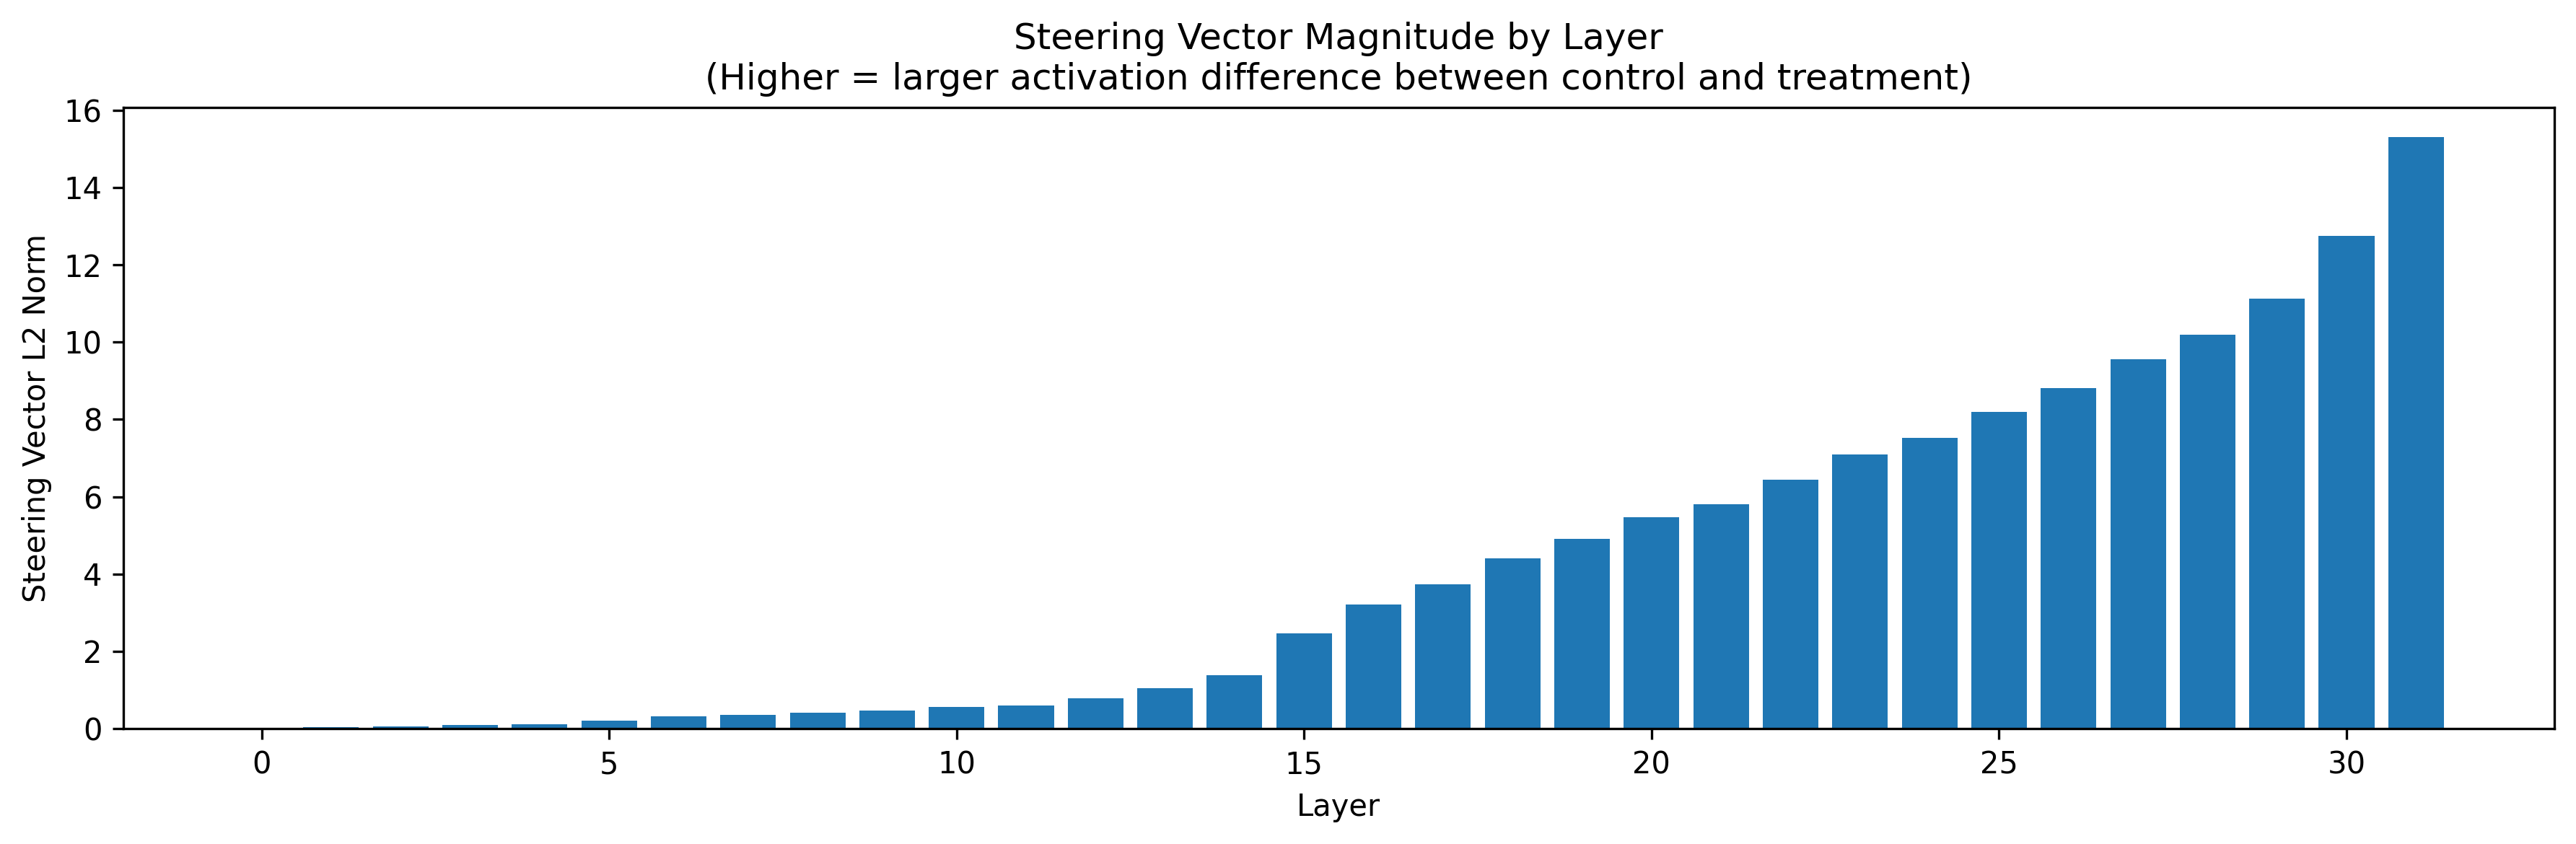


Top 5 layers by steering vector magnitude: [31, 30, 29, 28, 27]


In [58]:
# Analyze steering vector magnitudes across layers
# Larger magnitudes suggest layers where control vs treatment differ more

steering_norms = [steering_vectors[layer].norm().item() for layer in range(num_layers)]

plt.figure(figsize=(12, 4))
plt.bar(range(num_layers), steering_norms)
plt.xlabel("Layer")
plt.ylabel("Steering Vector L2 Norm")
plt.title("Steering Vector Magnitude by Layer\n(Higher = larger activation difference between control and treatment)")
plt.tight_layout()
plt.show()

# Find layers with strongest steering signal
top_layers = np.argsort(steering_norms)[::-1][:5]
print(f"\nTop 5 layers by steering vector magnitude: {top_layers.tolist()}")

In [59]:
# Save steering vectors for later use
torch.save(steering_vectors, 'steering_vectors_certainty.pt')
print("Saved steering vectors to steering_vectors_certainty.pt")

Saved steering vectors to steering_vectors_certainty.pt


## open / basic steering vectors

In [20]:
# open steering_vectors_certainty.pt
steering_vectors = torch.load('steering_vectors_certainty.pt')

In [21]:
# Function to get response with steering applied at a specific layer
def get_steered_response(prompt, layer_to_steer, steering_vector, steering_strength=1.0):
    """
    Generate a response while adding a steering vector to a specific layer's activations.
    
    Args:
        prompt: Input text
        layer_to_steer: Which layer index to add the steering vector to
        steering_vector: The steering vector to add
        steering_strength: Multiplier for the steering vector (can be negative to steer opposite direction)
    
    Returns:
        Generated response text
    """
    system_prompt = "You are a helpful assistant. Answer shortly with only your choice with no explanation."
    msg = get_message(prompt, system_prompt)
    inputs = tokenizer.apply_chat_template(msg, return_tensors="pt", add_generation_prompt=True, return_dict=True).to(device)
    
    layer_name = f"{LAYER_PREFIX}.{layer_to_steer}"
    
    # Create a hook function that adds the steering vector
    def steering_hook(module, input, output):
        if isinstance(output, tuple):
            hidden_states = output[0]
            # Add steering vector to all positions (or just last token)
            hidden_states[:, -1, :] += steering_strength * steering_vector.to(hidden_states.dtype)
            return (hidden_states,) + output[1:]
        else:
            output[:, -1, :] += steering_strength * steering_vector.to(output.dtype)
            return output
    
    # Register the hook
    layer_module = dict(model.named_modules())[layer_name]
    hook_handle = layer_module.register_forward_hook(steering_hook)
    
    try:
        with torch.no_grad():
            gen = model.generate(**inputs, max_new_tokens=200, pad_token_id=tokenizer.eos_token_id, do_sample=False)
        response = tokenizer.decode(gen[0][len(inputs.input_ids[0]):], skip_special_tokens=True)
    finally:
        hook_handle.remove()
    
    return response

In [22]:
# Test steering on held-out examples from df_switch_test
# We'll try steering the control question toward certainty bias (positive direction)
# and steering the treatment question away from certainty bias (negative direction)

# Pick a test example
test_idx = 3
test_example = df_switch_test.iloc[test_idx]
control_text = test_example['control_text']
treatment_text = test_example['treatment_text']

print("=" * 80)
print("TEST EXAMPLE")
print("=" * 80)
print(f"\nCONTROL prompt:\n{control_text}")
print(f"\nTREATMENT prompt:\n{treatment_text}")
print(f"\nOriginal control response: {test_example['control_resp']}")
print(f"Original treatment response: {test_example['treatment_resp']}")

TEST EXAMPLE

CONTROL prompt:
Choose between:
Option A - 30% to win $4000, 70% to win $0.
Option B - $5000 with a 25% chance, $0 with a 75% chance.
What is your choice?
Answer:

TREATMENT prompt:
Choose between:
Option A - $4000 for sure.
Option B - $5000 with a 85% chance, $0 with a 15% chance.
What is your choice?
Answer:

Original control response: B
Original treatment response: A


In [26]:
# Test steering at different layers and strengths
# Using top layers by steering magnitude

print("\n" + "=" * 80)
print("STEERING EXPERIMENTS")
print("=" * 80)

# Test on control prompt: can we induce certainty bias by adding steering vector?
print("\n--- Steering CONTROL prompt toward certainty (adding steering vector) ---")
for layer in range(num_layers):
    for strength in [0.5, 1.0, 2.0]:
        steered_resp = get_steered_response(control_text, layer, steering_vectors[layer], strength)
        print(f"Layer {layer}, strength {strength}: {parse_answer(steered_resp)} (full: {steered_resp[:50]})")

# Test on treatment prompt: can we reduce certainty bias by subtracting steering vector?
print("\n--- Steering TREATMENT prompt away from certainty (subtracting steering vector) ---")
for layer in range(num_layers):
    for strength in [-0.5, -1.0, -2.0]:
        steered_resp = get_steered_response(treatment_text, layer, steering_vectors[layer], strength)
        print(f"Layer {layer}, strength {strength}: {parse_answer(steered_resp)} (full: {steered_resp[:50]})")


STEERING EXPERIMENTS

--- Steering CONTROL prompt toward certainty (adding steering vector) ---
Layer 0, strength 0.5: B (full: Option B)
Layer 0, strength 1.0: B (full: Option B)
Layer 0, strength 2.0: B (full: Option B)
Layer 1, strength 0.5: B (full: Option B)
Layer 1, strength 1.0: B (full: Option B)
Layer 1, strength 2.0: B (full: B)
Layer 2, strength 0.5: B (full: Option B)
Layer 2, strength 1.0: B (full: Option B)
Layer 2, strength 2.0: B (full: Option B)
Layer 3, strength 0.5: B (full: Option B)
Layer 3, strength 1.0: B (full: Option B)
Layer 3, strength 2.0: B (full: Option B)
Layer 4, strength 0.5: B (full: Option B)
Layer 4, strength 1.0: B (full: Option B)
Layer 4, strength 2.0: B (full: Option B)
Layer 5, strength 0.5: B (full: Option B)
Layer 5, strength 1.0: B (full: Option B)
Layer 5, strength 2.0: B (full: Option B)
Layer 6, strength 0.5: B (full: Option B)
Layer 6, strength 1.0: B (full: B)
Layer 6, strength 2.0: B (full: B)
Layer 7, strength 0.5: B (full: Option B)


## basic activation patching

In [27]:
# =============================================================================
# WORKFLOW 2: ACTIVATION PATCHING
# =============================================================================
# 
# WHAT IS ACTIVATION PATCHING?
# Activation patching (also called "causal tracing" or "interchange intervention")
# is a technique to identify which specific activations are causally responsible 
# for a model's behavior.
#
# The key idea:
# 1. Run the model on prompt A (e.g., control) and cache its activations
# 2. Run the model on prompt B (e.g., treatment) but REPLACE specific activations
#    (at certain layers/positions) with the cached activations from prompt A
# 3. Observe if the output changes - if it does, those activations were causally
#    important for the behavioral difference
#
# In our context:
# - The model answers "A" for control but "B" for treatment (certainty effect)
# - Question: Which layer(s) and position(s) are responsible for this switch?
# - Experiment: Run treatment, but patch in control activations at various points
# - If patching layer L makes treatment behave like control, then layer L is
#   causally responsible for the certainty effect
#
# This is more rigorous than just looking at activation differences because:
# - Correlational: "activations differ at layer L" doesn't prove causation
# - Causal: "patching layer L changes behavior" proves those activations matter

In [165]:
def cache_all_activations(prompt):
    """
    Run the model on a prompt and cache ALL layer activations at ALL token positions.
    
    Returns:
        cached: Dictionary mapping layer_idx -> tensor of shape [seq_len, hidden_size]
        seq_len: Length of the input sequence
    """
    system_prompt = "You are a helpful assistant. Answer shortly with only your choice with no explanation."
    msg = get_message(prompt, system_prompt)
    inputs = tokenizer.apply_chat_template(
        msg, return_tensors="pt", add_generation_prompt=True, return_dict=True
    ).to(device)

    layer_names = [f"{LAYER_PREFIX}.{i}" for i in range(num_layers)]
    cached = {}

    with torch.no_grad():
        with TraceDict(model, layer_names, retain_input=False, retain_output=True) as tr:
            outputs = model(**inputs)

        for layer_idx in range(num_layers):
            layer_output = tr[layer_names[layer_idx]].output
            if isinstance(layer_output, tuple):
                hidden_states = layer_output[0]
            else:
                hidden_states = layer_output
            # Store full sequence: [seq_len, hidden_size]
            cached[layer_idx] = hidden_states[0].clone()

    return cached, inputs.input_ids.shape[1]


def run_with_patching(
    prompt,
    cached_activations,
    layers_to_patch,
    positions_to_patch="last",
    generate=False,
    max_new_tokens=200,
):
    """
    Run model on a prompt but replace activations at specified layers/positions
    with cached activations from another prompt.

    Args:
        prompt: The prompt to run (e.g., treatment)
        cached_activations: Cached activations from another prompt (e.g., control)
        layers_to_patch: List of layer indices to patch
        positions_to_patch: "last" for last token, "all" for all tokens, or list of indices
        generate: If True, use model.generate() (patches only during prefill).
                  If False, do a single forward pass and return next-token logits.
        max_new_tokens: Max tokens to generate (only used if generate=True)

    Returns:
        If generate=True: the decoded response string
        If generate=False: dict with 'logits' (next-token logits), 'top_token' (greedy pick),
                           and 'top_token_str' (decoded string)
    """
    system_prompt = "You are a helpful assistant. Answer shortly with only your choice with no explanation."
    msg = get_message(prompt, system_prompt)
    inputs = tokenizer.apply_chat_template(
        msg, return_tensors="pt", add_generation_prompt=True, return_dict=True
    ).to(device)

    prefill_seq_len = inputs.input_ids.shape[1]
    hooks = []

    for layer_idx in layers_to_patch:
        layer_name = f"{LAYER_PREFIX}.{layer_idx}"
        cached_act = cached_activations[layer_idx]

        def make_patch_hook(cached, positions, expected_prefill_len):
            def hook(module, input, output):
                is_tuple = isinstance(output, tuple)
                hidden_states = output[0] if is_tuple else output
                seq_len = hidden_states.shape[1]

                # During generation, skip autoregressive steps (seq_len=1).
                # Only patch during the prefill pass.
                if seq_len <= 1:
                    return output

                hidden_states = hidden_states.clone()

                if positions == "last":
                    hidden_states[0, -1, :] = cached[-1, :].to(hidden_states.dtype)
                elif positions == "all":
                    min_len = min(seq_len, cached.shape[0])
                    hidden_states[0, :min_len, :] = cached[:min_len, :].to(
                        hidden_states.dtype
                    )
                else:
                    for pos in positions:
                        if pos < seq_len and pos < cached.shape[0]:
                            hidden_states[0, pos, :] = cached[pos, :].to(
                                hidden_states.dtype
                            )

                if is_tuple:
                    return (hidden_states,) + output[1:]
                return hidden_states

            return hook

        layer_module = dict(model.named_modules())[layer_name]
        handle = layer_module.register_forward_hook(
            make_patch_hook(cached_act, positions_to_patch, prefill_seq_len)
        )
        hooks.append(handle)

    try:
        with torch.no_grad():
            if generate:
                gen = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    pad_token_id=tokenizer.eos_token_id,
                    do_sample=False,
                )
                response = tokenizer.decode(
                    gen[0][len(inputs.input_ids[0]) :], skip_special_tokens=True
                )
                return response
            else:
                outputs = model(**inputs)
                logits = outputs.logits[0, -1, :]  # next-token logits
                top_token = logits.argmax().item()
                return {
                    "logits": logits,
                    "top_token": top_token,
                    "top_token_str": tokenizer.decode(top_token),
                }
    finally:
        for h in hooks:
            h.remove()

In [190]:
# Select one question pair for the activation patching experiment
# We'll use the first example from df_switch_train

patch_example = df_switch_train.iloc[14]
control_prompt = patch_example['control_text']
treatment_prompt = patch_example['treatment_text']

print("ACTIVATION PATCHING EXAMPLE")
print("=" * 80)
print(f"\nControl prompt:\n{control_prompt}")
print(f"\nTreatment prompt:\n{treatment_prompt}")
print(f"\nControl response: {patch_example['control_resp']}")
print(f"Treatment response: {patch_example['treatment_resp']}")

ACTIVATION PATCHING EXAMPLE

Control prompt:
Below you will find two options for getting a prize.
Option A - 20% to win $3000, 80% to win $0.
Option B - 25% to win $2000, 75% to win $0.
Given that these are the only options, which one would you choose?
Answer:

Treatment prompt:
Below you will find two options for getting a prize.
Option A - 70% to win $3000, 30% to win $0.
Option B - $2000 for sure.
Given that these are the only options, which one would you choose?
Answer:

Control response: A
Treatment response: B


In [191]:
# Step 1: Cache activations from the control prompt
print("Caching activations from control prompt...")
control_cached, control_seq_len = cache_all_activations(control_prompt)
print(f"Cached activations for {len(control_cached)} layers, sequence length {control_seq_len}")

Caching activations from control prompt...
Cached activations for 32 layers, sequence length 96


In [192]:
# Step 2: Run treatment with patching at each layer individually
# This identifies which layer(s) are causally responsible for the behavioral difference

print("\n" + "=" * 80)
print("LAYER-BY-LAYER PATCHING: Treatment + Control activations at layer L")
print("=" * 80)
print(f"Baseline treatment response: {patch_example['treatment_resp']}")
print(f"Target (control) response: {patch_example['control_resp']}")
print("-" * 80)

patching_results = []

for layer in tqdm(range(num_layers)):
    patched_resp = run_with_patching(treatment_prompt, control_cached, [layer], "last", generate=True, max_new_tokens=5)
    parsed = parse_answer(patched_resp)
    patching_results.append({
        'layer': layer,
        'response': parsed,
        'full_response': patched_resp[:50],
        'flipped': parsed == patch_example['control_resp']
    })

# Show results
df_patch_results = pd.DataFrame(patching_results)
print("\nPatching results (showing layers where response flipped to control's answer):")
flipped_layers = df_patch_results[df_patch_results['flipped']]
if len(flipped_layers) > 0:
    print(flipped_layers)
else:
    print("No individual layer patching caused a flip.")


LAYER-BY-LAYER PATCHING: Treatment + Control activations at layer L
Baseline treatment response: B
Target (control) response: A
--------------------------------------------------------------------------------


100%|██████████| 32/32 [00:01<00:00, 22.90it/s]


Patching results (showing layers where response flipped to control's answer):
    layer response full_response  flipped
16     16        A             A     True
17     17        A             A     True
18     18        A             A     True
19     19        A             A     True
20     20        A             A     True
21     21        A             A     True
22     22        A             A     True
23     23        A             A     True
24     24        A             A     True
25     25        A             A     True
26     26        A             A     True
27     27        A             A     True
28     28        A             A     True
29     29        A             A     True
30     30        A             A     True
31     31        A             A     True


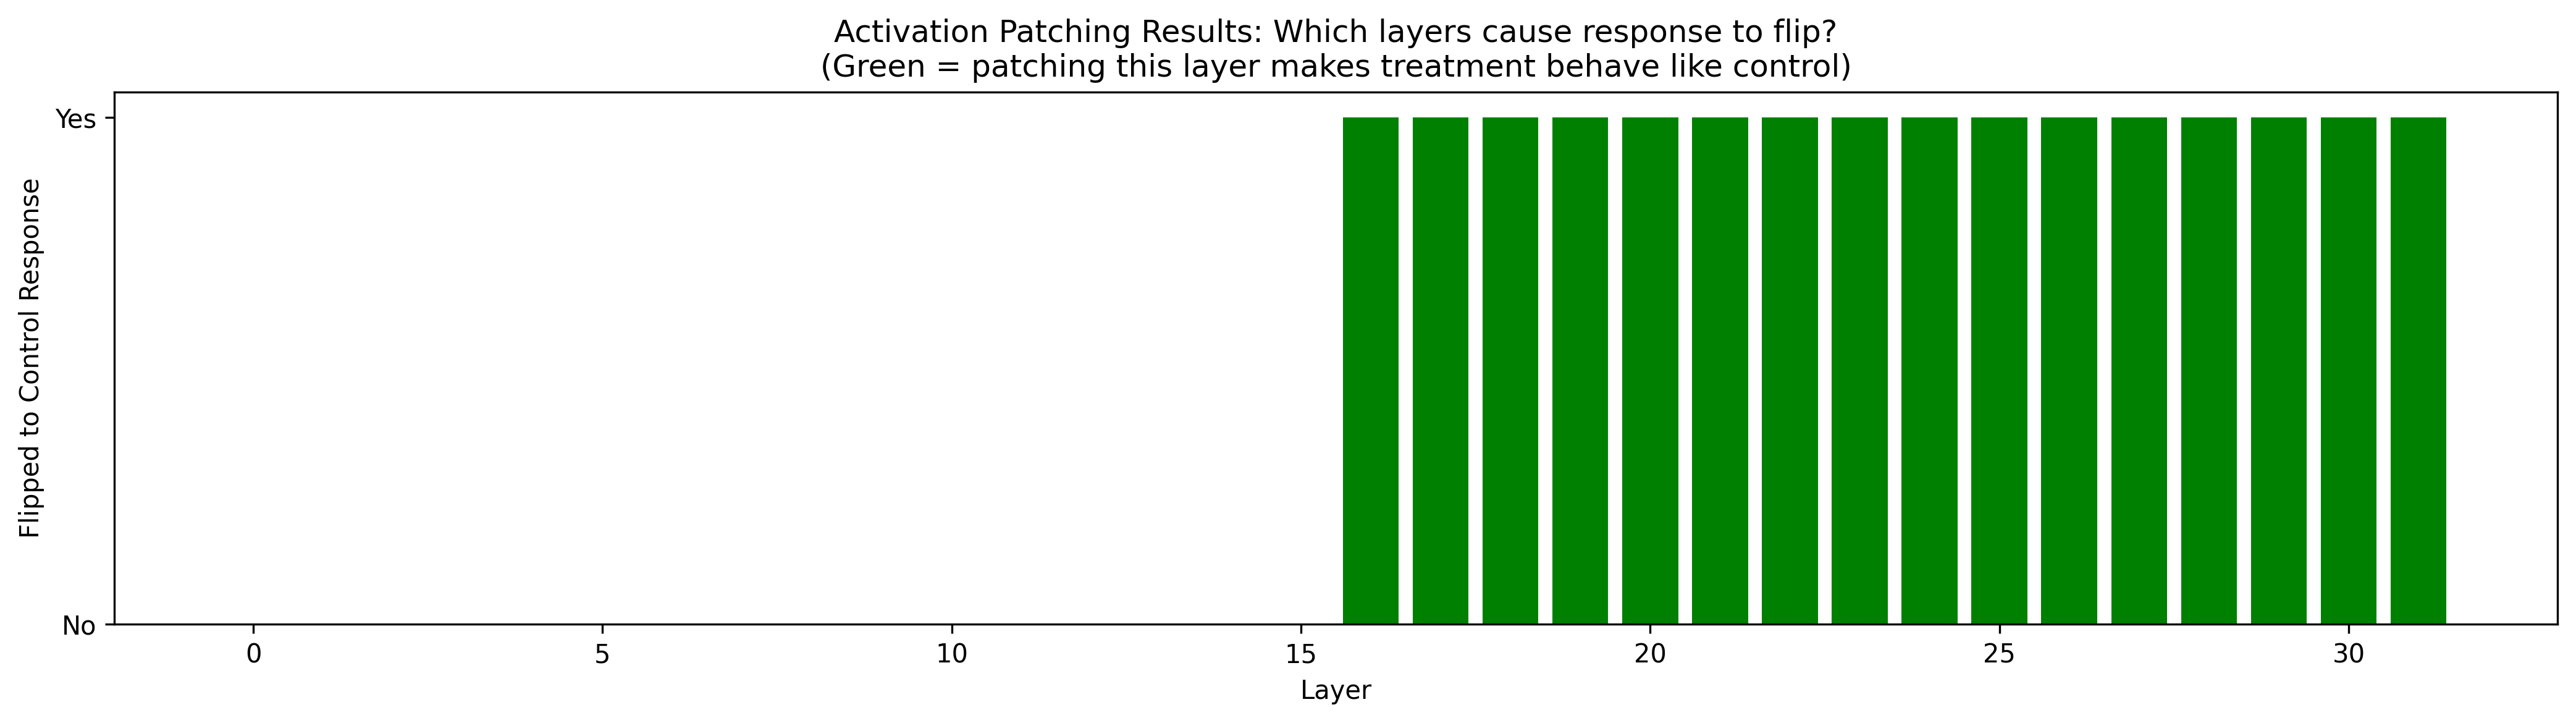


Summary: Patching at 16 out of 32 layers flipped the response.


In [193]:
# Visualize patching results
# Show which layers, when patched, flip the response

plt.figure(figsize=(14, 4))

# Create a binary indicator: 1 if flipped to control, 0 otherwise
flip_indicator = [1 if r['flipped'] else 0 for r in patching_results]

plt.bar(range(num_layers), flip_indicator, color=['green' if f else 'lightgray' for f in flip_indicator])
plt.xlabel("Layer")
plt.ylabel("Flipped to Control Response")
plt.title("Activation Patching Results: Which layers cause response to flip?\n(Green = patching this layer makes treatment behave like control)")
plt.yticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()

print(f"\nSummary: Patching at {sum(flip_indicator)} out of {num_layers} layers flipped the response.")

In [195]:
# Advanced patching: Patch ranges of layers to find the critical window
# Sometimes a single layer isn't enough - we need to patch a contiguous range

print("\n" + "=" * 80)
print("RANGE PATCHING: Find critical layer windows")
print("=" * 80)

# Try patching layers [start:start+window_size] for various starts and sizes
window_sizes = [3, 5, 7]
range_results = []

for window_size in window_sizes:
    print(f"\nTesting window size {window_size}...")
    for start_layer in range(0, num_layers - window_size + 1, 2):  # step by 2 for efficiency
        layers_to_patch = list(range(start_layer, start_layer + window_size))
        patched_resp = run_with_patching(treatment_prompt, control_cached, layers_to_patch, "last", generate=True, max_new_tokens=5)
        parsed = parse_answer(patched_resp)
        range_results.append({
            'window_size': window_size,
            'start_layer': start_layer,
            'end_layer': start_layer + window_size - 1,
            'response': parsed,
            'flipped': parsed == patch_example['control_resp']
        })

df_range_results = pd.DataFrame(range_results)
print("\nRange patching results (showing ranges that flipped the response):")
flipped_ranges = df_range_results[df_range_results['flipped']]
if len(flipped_ranges) > 0:
    print(flipped_ranges[['window_size', 'start_layer', 'end_layer', 'response']])
else:
    print("No layer ranges caused a flip.")


RANGE PATCHING: Find critical layer windows

Testing window size 3...

Testing window size 5...

Testing window size 7...

Range patching results (showing ranges that flipped the response):
    window_size  start_layer  end_layer response
7             3           14         16        A
8             3           16         18        A
9             3           18         20        A
10            3           20         22        A
11            3           22         24        A
12            3           24         26        A
13            3           26         28        A
14            3           28         30        A
21            5           12         16        A
22            5           14         18        A
23            5           16         20        A
24            5           18         22        A
25            5           20         24        A
26            5           22         26        A
27            5           24         28        A
28            5          

## a bit of logit lens

In [214]:
import matplotlib.ticker as mticker


def logit_lens_ab(prompt, token_a, token_b):
    """
    Track P(A) and P(B) at each layer using the logit lens.
    Applies the final layernorm + lm_head to each layer's residual stream.
    """
    cached, seq_len = cache_all_activations(prompt)

    # Adjust these attribute paths to your model architecture:
    #   Llama/Mistral: model.model.norm, model.lm_head
    #   GPT-2:         model.transformer.ln_f, model.lm_head
    #   Pythia:        model.gpt_neox.final_layer_norm, model.embed_out
    ln_f = model.model.norm
    lm_head = model.lm_head

    layers, pa, pb = [], [], []
    for layer_idx in range(num_layers):
        h = cached[layer_idx][-1:].unsqueeze(0)  # [1, 1, hidden_size]
        logits = lm_head(ln_f(h))[0, 0]
        p = torch.softmax(logits, dim=-1)
        layers.append(layer_idx)
        pa.append(p[token_a].item())
        pb.append(p[token_b].item())

    return {"layer": layers, "P(A)": pa, "P(B)": pb}


def get_ab_tokens():
    """Get token IDs for A and B, handling different tokenizer conventions."""
    for fmt in ["A", " A", "(A"]:
        ids = tokenizer.encode(fmt, add_special_tokens=False)
        if len(ids) == 1:
            token_a = ids[0]
            break
    else:
        token_a = tokenizer.encode("A", add_special_tokens=False)[-1]

    for fmt in ["B", " B", "(B"]:
        ids = tokenizer.encode(fmt, add_special_tokens=False)
        if len(ids) == 1:
            token_b = ids[0]
            break
    else:
        token_b = tokenizer.encode("B", add_special_tokens=False)[-1]

    print(f"Token A: {token_a} -> '{tokenizer.decode(token_a)}'")
    print(f"Token B: {token_b} -> '{tokenizer.decode(token_b)}'")
    return token_a, token_b


def plot_trajectories(control_prompt, treatment_prompt, token_a, token_b, title=None):
    """
    Plot P(A) and P(B) across layers for both control and treatment prompts.
    Four lines total: control P(A), control P(B), treatment P(A), treatment P(B).
    """
    control = logit_lens_ab(control_prompt, token_a, token_b)
    treatment = logit_lens_ab(treatment_prompt, token_a, token_b)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # ── Panel 1: Control prompt ──────────────────────────────────
    ax = axes[0]
    ax.plot(control["layer"], control["P(A)"], color="#2563eb", linewidth=2, label="P(A)")
    ax.plot(control["layer"], control["P(B)"], color="#dc2626", linewidth=2, label="P(B)")
    ax.fill_between(control["layer"], control["P(A)"], control["P(B)"],
                     where=[a > b for a, b in zip(control["P(A)"], control["P(B)"])],
                     alpha=0.08, color="#2563eb")
    ax.fill_between(control["layer"], control["P(A)"], control["P(B)"],
                     where=[b > a for a, b in zip(control["P(A)"], control["P(B)"])],
                     alpha=0.08, color="#dc2626")
    ax.set_title("Control prompt", fontsize=13, fontweight="bold")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Probability")
    ax.legend(frameon=True, fancybox=False, edgecolor="#ccc")
    ax.set_ylim(-0.02, 1.02)
    ax.grid(True, alpha=0.3)

    # ── Panel 2: Treatment prompt ────────────────────────────────
    ax = axes[1]
    ax.plot(treatment["layer"], treatment["P(A)"], color="#2563eb", linewidth=2, label="P(A)")
    ax.plot(treatment["layer"], treatment["P(B)"], color="#dc2626", linewidth=2, label="P(B)")
    ax.fill_between(treatment["layer"], treatment["P(A)"], treatment["P(B)"],
                     where=[a > b for a, b in zip(treatment["P(A)"], treatment["P(B)"])],
                     alpha=0.08, color="#2563eb")
    ax.fill_between(treatment["layer"], treatment["P(A)"], treatment["P(B)"],
                     where=[b > a for a, b in zip(treatment["P(A)"], treatment["P(B)"])],
                     alpha=0.08, color="#dc2626")
    ax.set_title("Treatment prompt", fontsize=13, fontweight="bold")
    ax.set_xlabel("Layer")
    ax.set_ylim(-0.02, 1.02)
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=True, fancybox=False, edgecolor="#ccc")

    # ── Panel 3: Difference (logit lens "tug of war") ────────────
    ax = axes[2]
    control_diff = [a - b for a, b in zip(control["P(A)"], control["P(B)"])]
    treatment_diff = [a - b for a, b in zip(treatment["P(A)"], treatment["P(B)"])]
    ax.plot(control["layer"], control_diff, color="#7c3aed", linewidth=2, label="Control: P(A)−P(B)")
    ax.plot(treatment["layer"], treatment_diff, color="#ea580c", linewidth=2, label="Treatment: P(A)−P(B)")
    ax.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.5)

    # Mark crossover points
    for name, diff, color in [("Control", control_diff, "#7c3aed"),
                               ("Treatment", treatment_diff, "#ea580c")]:
        for i in range(1, len(diff)):
            if diff[i - 1] * diff[i] < 0:  # sign change
                # Linear interpolation for exact crossing
                x_cross = control["layer"][i - 1] + abs(diff[i - 1]) / (abs(diff[i - 1]) + abs(diff[i]))
                ax.axvline(x_cross, color=color, linewidth=0.8, linestyle=":", alpha=0.6)
                ax.annotate(f"{name}\ncrossover\nL≈{x_cross:.1f}",
                           xy=(x_cross, 0), fontsize=8, ha="center", va="bottom",
                           color=color, fontweight="bold")

    ax.set_title("P(A) − P(B) across layers", fontsize=13, fontweight="bold")
    ax.set_xlabel("Layer")
    ax.set_ylabel("P(A) − P(B)")
    ax.legend(frameon=True, fancybox=False, edgecolor="#ccc")
    ax.grid(True, alpha=0.3)

    if title:
        fig.suptitle(title, fontsize=15, fontweight="bold", y=1.02)

    plt.tight_layout()
    plt.savefig("logit_lens_trajectories.png", dpi=150, bbox_inches="tight")
    plt.show()

    return control, treatment


def plot_trajectory_grid(prompts_pairs, token_a, token_b):
    """
    Plot trajectories for multiple question pairs.

    Args:
        prompts_pairs: list of dicts, each with:
            {"control": str, "treatment": str, "label": str}
        token_a, token_b: token IDs
    """
    n = len(prompts_pairs)
    fig, axes = plt.subplots(n, 2, figsize=(14, 4 * n), squeeze=False)

    for row, pair in enumerate(prompts_pairs):
        control = logit_lens_ab(pair["control"], token_a, token_b)
        treatment = logit_lens_ab(pair["treatment"], token_a, token_b)

        control_diff = [a - b for a, b in zip(control["P(A)"], control["P(B)"])]
        treatment_diff = [a - b for a, b in zip(treatment["P(A)"], treatment["P(B)"])]

        # Left: raw probabilities
        ax = axes[row][0]
        ax.plot(control["layer"], control["P(A)"], color="#2563eb", linewidth=1.5,
                linestyle="-", label="Ctrl P(A)")
        ax.plot(control["layer"], control["P(B)"], color="#dc2626", linewidth=1.5,
                linestyle="-", label="Ctrl P(B)")
        ax.plot(treatment["layer"], treatment["P(A)"], color="#2563eb", linewidth=1.5,
                linestyle="--", label="Treat P(A)")
        ax.plot(treatment["layer"], treatment["P(B)"], color="#dc2626", linewidth=1.5,
                linestyle="--", label="Treat P(B)")
        ax.set_ylabel("Probability")
        ax.set_ylim(-0.02, 1.02)
        ax.grid(True, alpha=0.3)
        ax.set_title(pair.get("label", f"Pair {row + 1}"), fontsize=11, fontweight="bold")
        if row == 0:
            ax.legend(fontsize=8, frameon=True, fancybox=False, edgecolor="#ccc")
        if row == n - 1:
            ax.set_xlabel("Layer")

        # Right: difference
        ax = axes[row][1]
        ax.plot(control["layer"], control_diff, color="#7c3aed", linewidth=2,
                label="Ctrl P(A)−P(B)")
        ax.plot(treatment["layer"], treatment_diff, color="#ea580c", linewidth=2,
                label="Treat P(A)−P(B)")
        ax.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.5)
        ax.set_ylabel("P(A) − P(B)")
        ax.grid(True, alpha=0.3)
        if row == 0:
            ax.legend(fontsize=8, frameon=True, fancybox=False, edgecolor="#ccc")
        if row == n - 1:
            ax.set_xlabel("Layer")

    plt.tight_layout()
    plt.savefig("logit_lens_grid.png", dpi=150, bbox_inches="tight")
    plt.show()

Token A: 32 -> 'A'
Token B: 33 -> 'B'


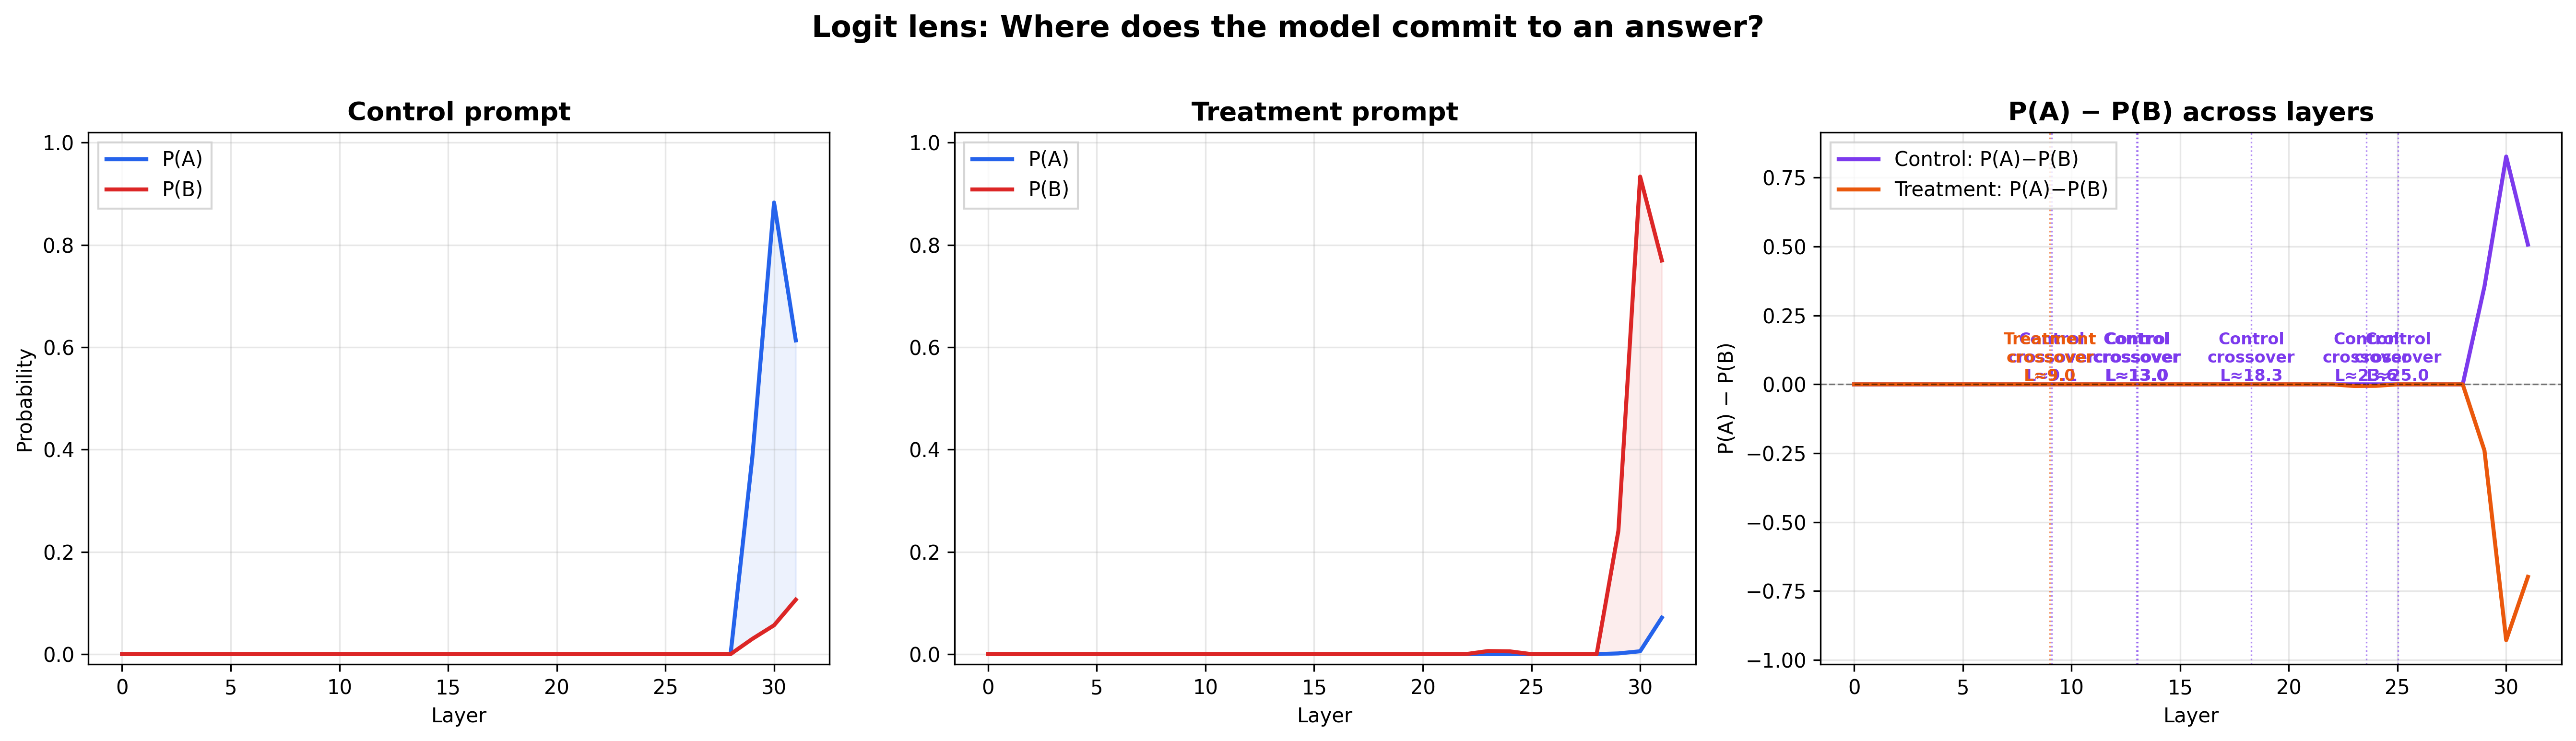

In [216]:
token_a, token_b = get_ab_tokens()

ctrl_data, treat_data = plot_trajectories(
    control_prompt, treatment_prompt, token_a, token_b,
    title="Logit lens: Where does the model commit to an answer?"
)

In [217]:
def logit_diff_attribution(prompt, token_a, token_b):
    """
    How much does each layer's residual contribution push toward A vs B?
    """
    cached, seq_len = cache_all_activations(prompt)
    lm_head = model.lm_head

    # Unembedding direction for A vs B
    w_a = lm_head.weight[token_a]  # [hidden_size]
    w_b = lm_head.weight[token_b]
    diff_dir = (w_a - w_b).float()  # direction that favors A over B

    contributions = []
    for layer_idx in range(num_layers):
        if layer_idx == 0:
            delta = cached[layer_idx][-1].float()
        else:
            delta = (cached[layer_idx][-1] - cached[layer_idx - 1][-1]).float()

        # Project this layer's contribution onto the A-vs-B direction
        contrib = torch.dot(delta, diff_dir).item()
        contributions.append(contrib)

    return contributions


def plot_logit_diff_attribution(control_prompt, treatment_prompt, token_a, token_b):
    ctrl_contrib = logit_diff_attribution(control_prompt, token_a, token_b)
    treat_contrib = logit_diff_attribution(treatment_prompt, token_a, token_b)

    fig, ax = plt.subplots(figsize=(12, 5))
    x = np.arange(num_layers)
    width = 0.35

    ax.bar(x - width / 2, ctrl_contrib, width, label="Control", color="#7c3aed", alpha=0.8)
    ax.bar(x + width / 2, treat_contrib, width, label="Treatment", color="#ea580c", alpha=0.8)
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Contribution to logit(A) − logit(B)")
    ax.set_title("Per-layer contribution to answer selection")
    ax.legend()
    ax.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()
    plt.savefig("logit_diff_attribution.png", dpi=150, bbox_inches="tight")
    plt.show()

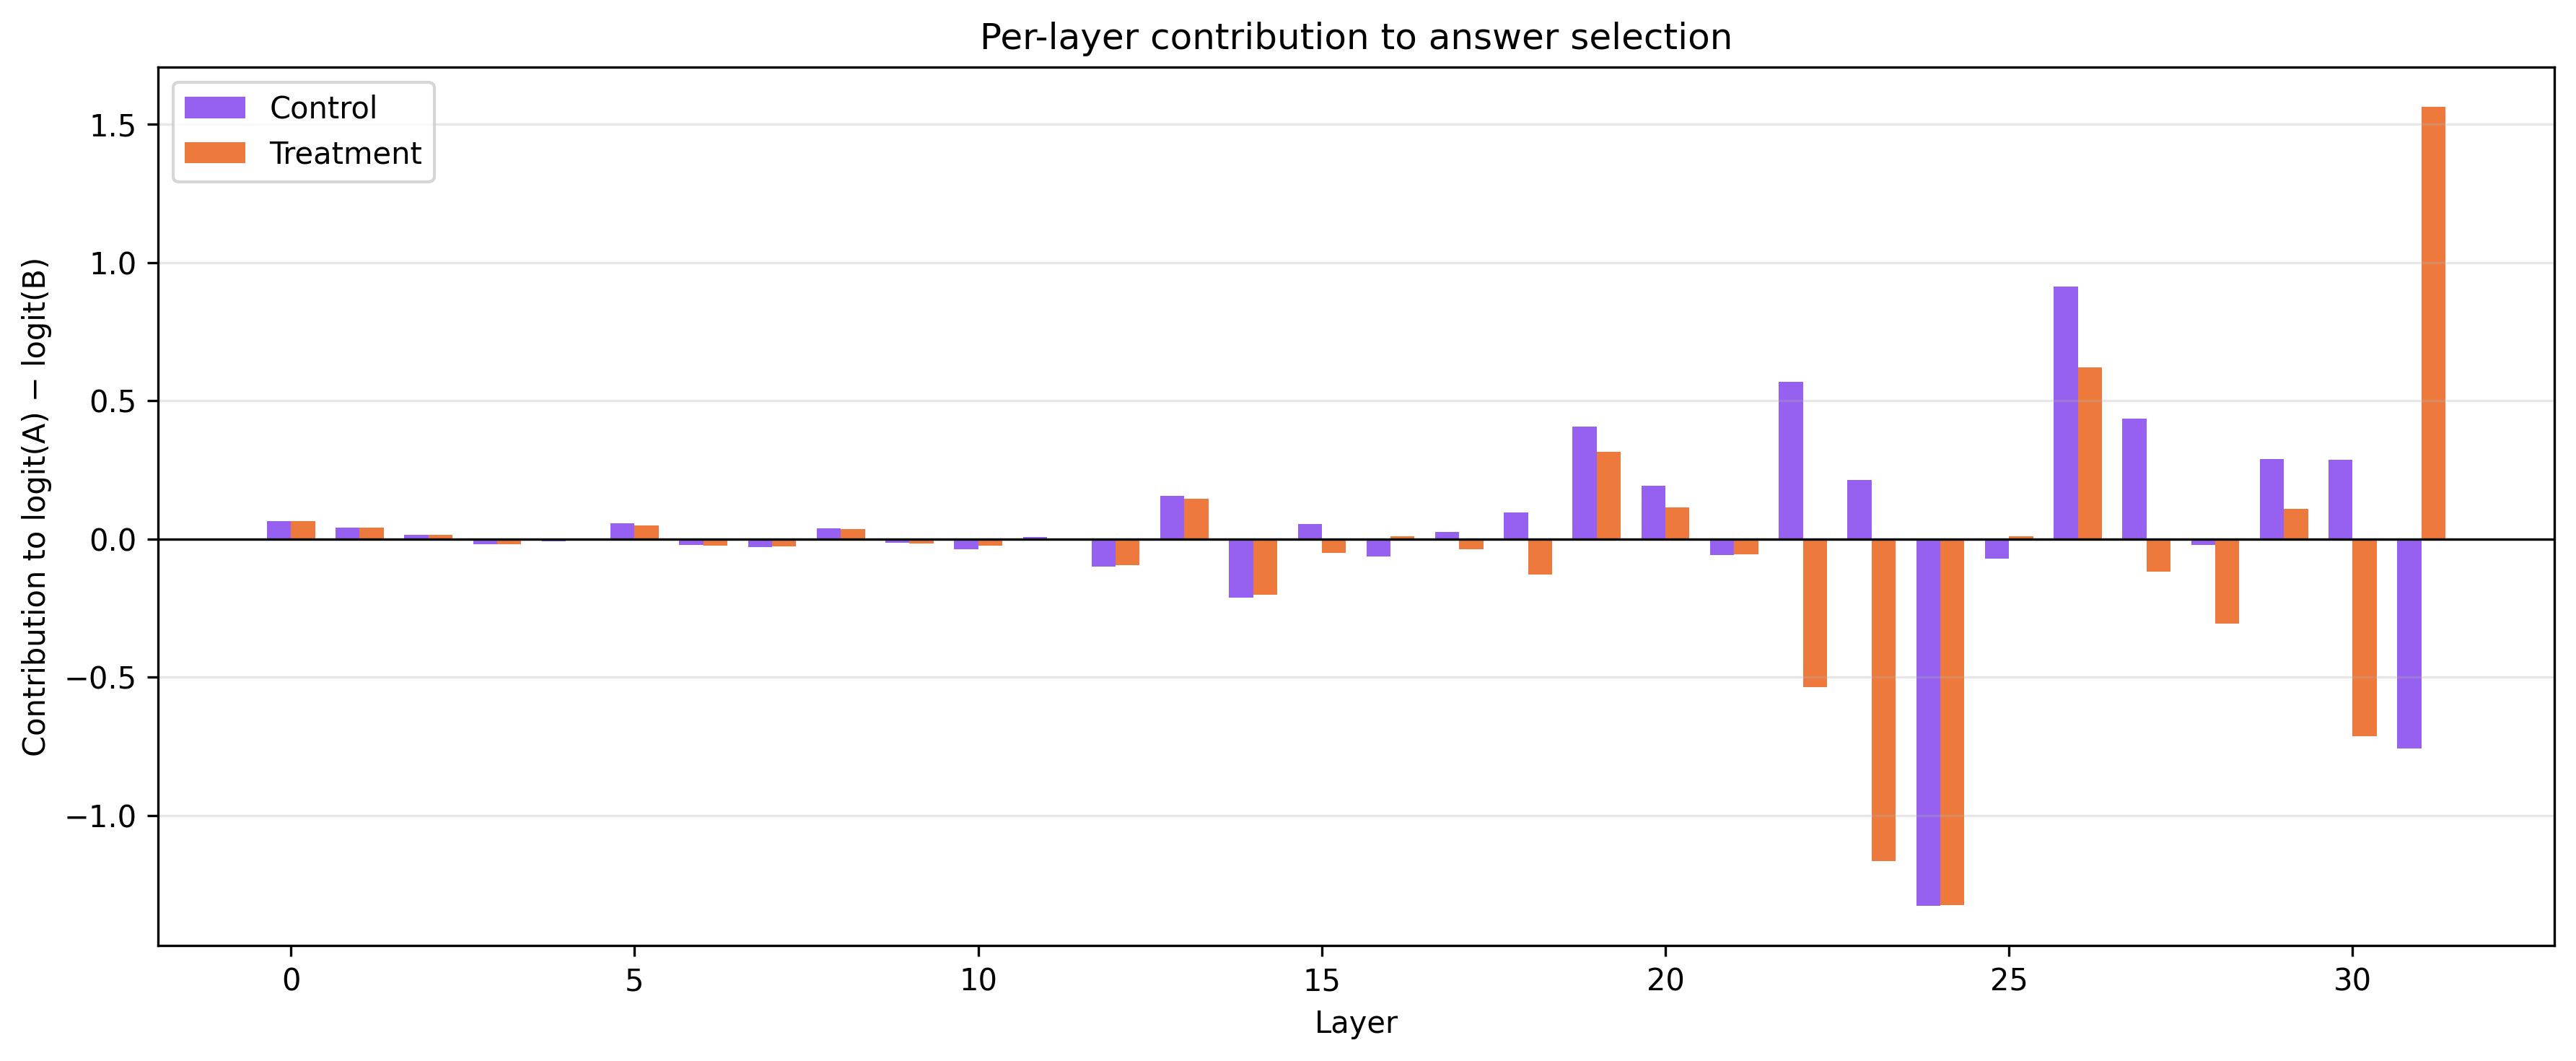

In [218]:
plot_logit_diff_attribution(control_prompt, treatment_prompt, token_a, token_b)

## patch the whole set

In [197]:
# =============================================================================
# FULL DATASET SINGLE-LAYER PATCHING EXPERIMENT
# =============================================================================
# For each question pair in df_switch, we:
# 1. Cache control activations
# 2. Run treatment prompt with patching at each layer individually
# 3. Record whether the response flipped to match the control response
# 4. Save all results for analysis

def run_single_layer_patching_experiment(df, save_path='patching_results_single_layer.csv'):
    """
    Run single-layer activation patching for every question pair in the dataframe.
    
    For each pair:
    - Cache activations from the control prompt
    - Run treatment prompt with control activations patched at each layer
    - Record if the response flipped to the control's answer
    
    Args:
        df: DataFrame with columns 'control_text', 'treatment_text', 'control_resp', 'treatment_resp'
        save_path: Path to save the results CSV
    
    Returns:
        DataFrame with patching results for all pairs and layers
    """
    all_results = []
    
    for pair_idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing question pairs"):
        control_text = row['control_text']
        treatment_text = row['treatment_text']
        original_control_resp = row['control_resp']
        original_treatment_resp = row['treatment_resp']
        
        # Cache activations from control prompt
        control_cached, control_seq_len = cache_all_activations(control_text)
        
        # Patch each layer individually
        for layer in range(num_layers):
            # Run treatment with control activations patched at this layer (last token position)
            patched_resp_full = run_with_patching(
                treatment_text, 
                control_cached, 
                layers_to_patch=[layer], 
                positions_to_patch="last", 
                generate=True, 
                max_new_tokens=5
            )
            patched_resp_parsed = parse_answer(patched_resp_full)
            
            # Check if response flipped to control's answer
            flipped_to_control = (patched_resp_parsed == original_control_resp and 
                                  original_treatment_resp != original_control_resp)
            
            # Also track direction of flip
            is_A_to_B = (original_treatment_resp == 'A' and patched_resp_parsed == 'B')
            is_B_to_A = (original_treatment_resp == 'B' and patched_resp_parsed == 'A')
            
            all_results.append({
                'pair_idx': pair_idx,
                'layer': layer,
                'control_text': control_text,
                'treatment_text': treatment_text,
                'original_control_resp': original_control_resp,
                'original_treatment_resp': original_treatment_resp,
                'patched_resp_full': patched_resp_full,
                'patched_resp_parsed': patched_resp_parsed,
                'flipped_to_control': flipped_to_control,
                'A_to_B': is_A_to_B,
                'B_to_A': is_B_to_A,
                'response_changed': patched_resp_parsed != original_treatment_resp
            })
    
    results_df = pd.DataFrame(all_results)
    
    # Save results
    if save_path:
        results_df.to_csv(save_path, index=False)
        print(f"\nSaved patching results to {save_path}")
    
    return results_df

In [198]:
# Run the single-layer patching experiment on df_switch (all question pairs with different responses)
print(f"Running single-layer patching on {len(df_switch)} question pairs across {num_layers} layers...")
print(f"Total patching experiments: {len(df_switch) * num_layers}")

patching_results = run_single_layer_patching_experiment(
    df=df_switch,
    save_path='patching_results_single_layer.csv'
)

print(f"\nResults shape: {patching_results.shape}")
print(f"Columns: {patching_results.columns.tolist()}")

Running single-layer patching on 99 question pairs across 32 layers...
Total patching experiments: 3168


Processing question pairs: 100%|██████████| 99/99 [02:24<00:00,  1.46s/it]


Saved patching results to patching_results_single_layer.csv

Results shape: (3168, 12)
Columns: ['pair_idx', 'layer', 'control_text', 'treatment_text', 'original_control_resp', 'original_treatment_resp', 'patched_resp_full', 'patched_resp_parsed', 'flipped_to_control', 'A_to_B', 'B_to_A', 'response_changed']


In [201]:
patching_results

,pair_idx,layer,control_text,treatment_text,original_control_resp,original_treatment_resp,patched_resp_full,patched_resp_parsed,flipped_to_control,A_to_B,B_to_A,response_changed
0,0,0,Choose between:\nOption A - $2500 with a 33% c...,Choose between:\nOption A - $2500 with a 33% c...,A,B,Option B,B,False,False,False,False
1,0,1,Choose between:\nOption A - $2500 with a 33% c...,Choose between:\nOption A - $2500 with a 33% c...,A,B,Option B,B,False,False,False,False
2,0,2,Choose between:\nOption A - $2500 with a 33% c...,Choose between:\nOption A - $2500 with a 33% c...,A,B,Option B,B,False,False,False,False
3,0,3,Choose between:\nOption A - $2500 with a 33% c...,Choose between:\nOption A - $2500 with a 33% c...,A,B,Option B,B,False,False,False,False
4,0,4,Choose between:\nOption A - $2500 with a 33% c...,Choose between:\nOption A - $2500 with a 33% c...,A,B,Option B,B,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3163,119,27,Which of the following would you prefer?\nOpti...,Which of the following would you prefer?\nOpti...,A,B,A,A,True,False,True,True
3164,119,28,Which of the following would you prefer?\nOpti...,Which of the following would you prefer?\nOpti...,A,B,A,A,True,False,True,True
3165,119,29,Which of the following would you prefer?\nOpti...,Which of the following would you prefer?\nOpti...,A,B,A,A,True,False,True,True
3166,119,30,Which of the following would you prefer?\nOpti...,Which of the following would you prefer?\nOpti...,A,B,A,A,True,False,True,True


Flip rate by layer:
       flip_rate  B_to_A_rate  A_to_B_rate
layer                                     
0       0.010101     0.000000     0.010101
1       0.000000     0.000000     0.000000
2       0.000000     0.000000     0.000000
3       0.010101     0.000000     0.010101
4       0.010101     0.000000     0.010101
5       0.000000     0.000000     0.000000
6       0.000000     0.000000     0.000000
7       0.010101     0.000000     0.010101
8       0.010101     0.000000     0.010101
9       0.010101     0.000000     0.010101
10      0.000000     0.000000     0.000000
11      0.000000     0.000000     0.000000
12      0.040404     0.030303     0.010101
13      0.111111     0.111111     0.000000
14      0.232323     0.212121     0.020202
15      0.434343     0.363636     0.070707
16      0.373737     0.353535     0.020202
17      0.444444     0.444444     0.000000
18      0.666667     0.505051     0.161616
19      0.585859     0.484848     0.101010
20      0.595960     0.474747     

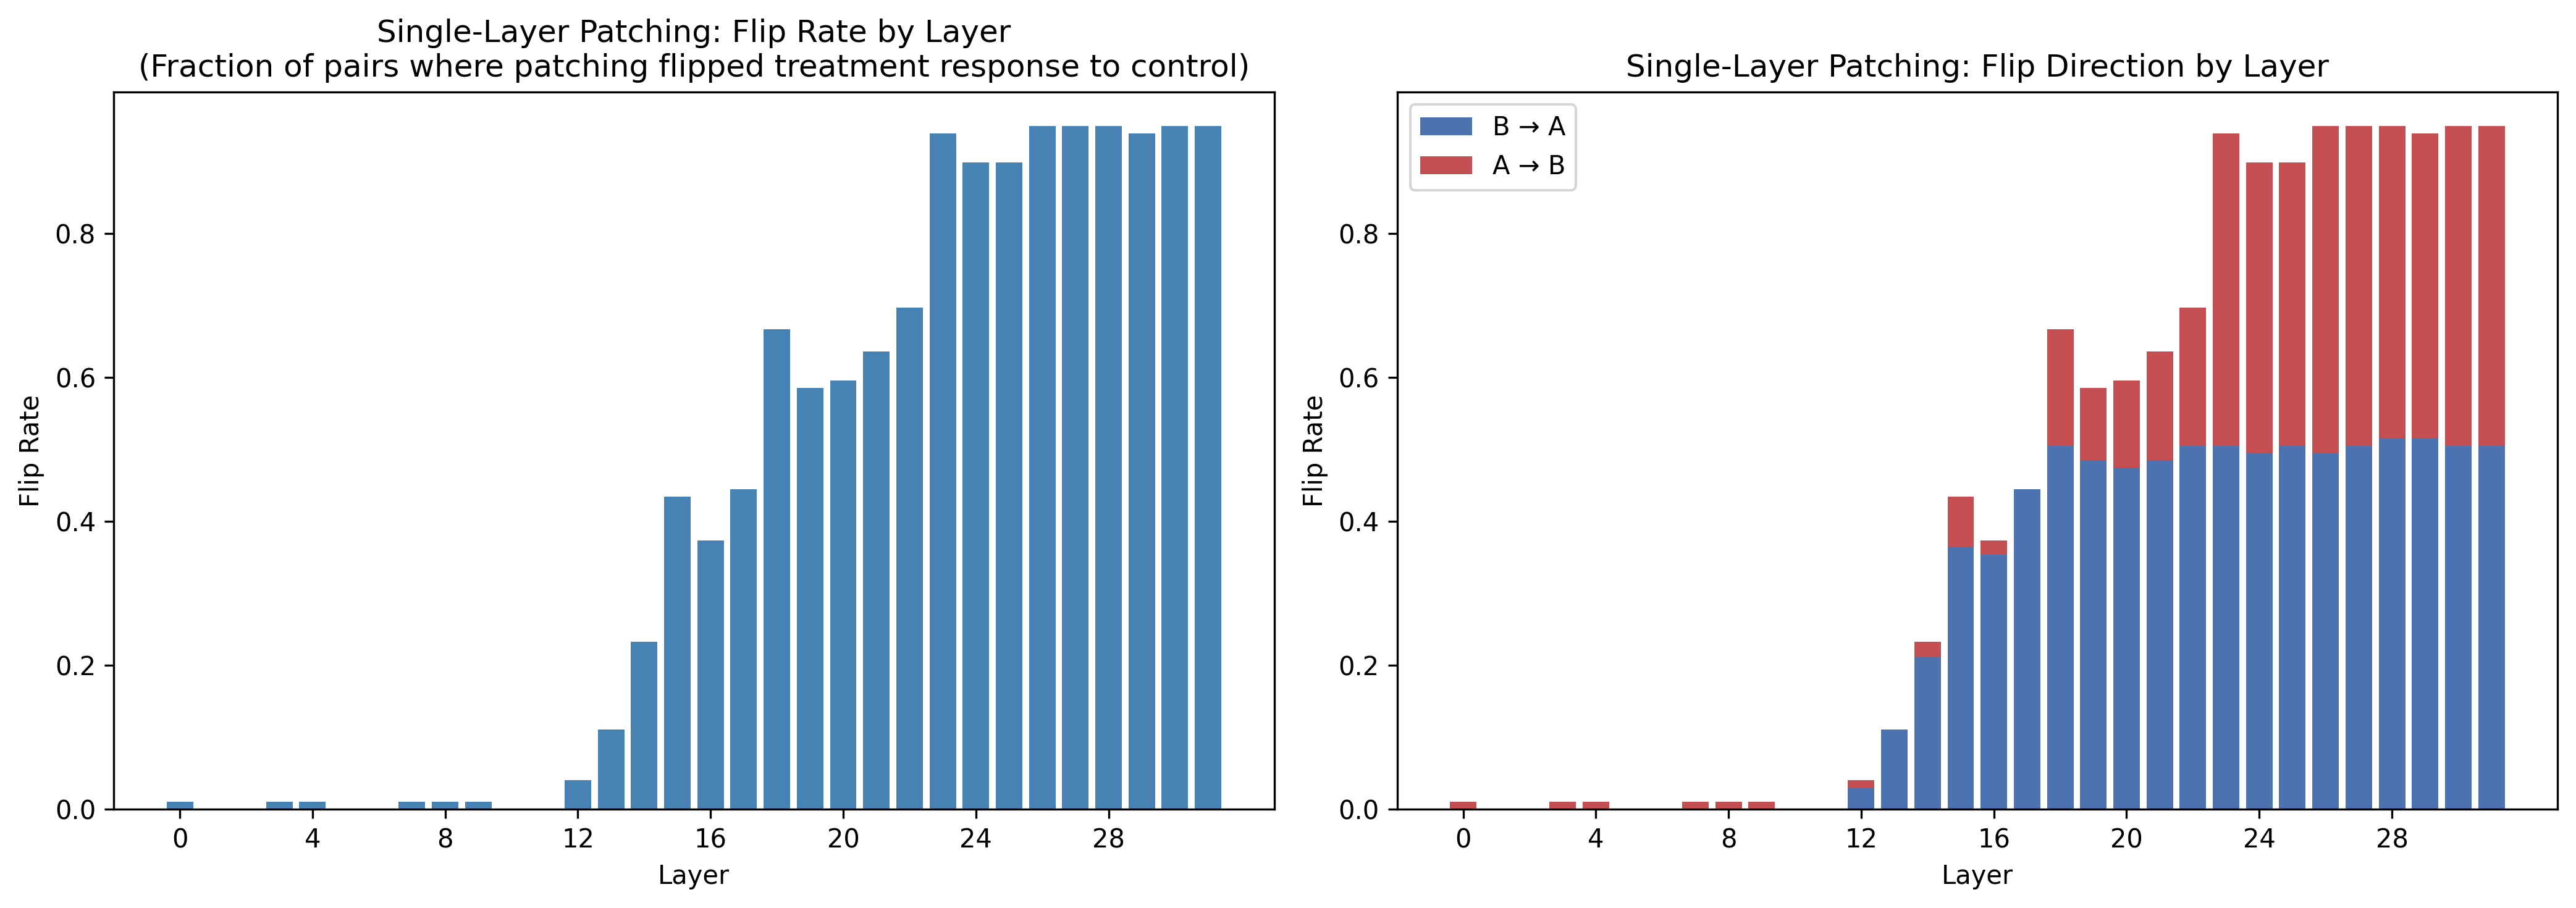

In [202]:
# Analyze and visualize the patching results

# Compute flip rate by layer
flip_rate_by_layer = patching_results.groupby('layer')['flipped_to_control'].mean()

# Compute flip direction breakdown
flip_direction = patching_results.groupby('layer').agg({
    'flipped_to_control': 'sum',
    'B_to_A': 'sum',
    'A_to_B': 'sum',
    'response_changed': 'sum',
    'pair_idx': 'count'
}).rename(columns={'pair_idx': 'total_pairs'})

flip_direction['flip_rate'] = flip_direction['flipped_to_control'] / flip_direction['total_pairs']
flip_direction['B_to_A_rate'] = flip_direction['B_to_A'] / flip_direction['total_pairs']
flip_direction['A_to_B_rate'] = flip_direction['A_to_B'] / flip_direction['total_pairs']

print("Flip rate by layer:")
print(flip_direction[['flip_rate', 'B_to_A_rate', 'A_to_B_rate']].to_string())

# Plot flip rate by layer
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overall flip rate
ax1 = axes[0]
ax1.bar(range(num_layers), flip_rate_by_layer.values, color='steelblue')
ax1.set_xlabel('Layer')
ax1.set_ylabel('Flip Rate')
ax1.set_title('Single-Layer Patching: Flip Rate by Layer\n(Fraction of pairs where patching flipped treatment response to control)')
ax1.set_xticks(range(0, num_layers, 4))

# Plot 2: Stacked bar showing B→A vs A→B
ax2 = axes[1]
layers = flip_direction.index
ax2.bar(layers, flip_direction['B_to_A_rate'], label='B → A', color='#4c72b0')
ax2.bar(layers, flip_direction['A_to_B_rate'], bottom=flip_direction['B_to_A_rate'], label='A → B', color='#c44e52')
ax2.set_xlabel('Layer')
ax2.set_ylabel('Flip Rate')
ax2.set_title('Single-Layer Patching: Flip Direction by Layer')
ax2.set_xticks(range(0, num_layers, 4))
ax2.legend()

plt.tight_layout()
plt.savefig('patching_single_layer_results.png', dpi=300, bbox_inches='tight')
plt.show()

# # Summary statistics
# print(f"\n{'='*60}")
# print("SUMMARY STATISTICS")
# print(f"{'='*60}")
# print(f"Total question pairs: {len(df_switch)}")
# print(f"Total patching experiments: {len(patching_results)}")
# print(f"Overall flip rate: {patching_results['flipped_to_control'].mean():.1%}")
# print(f"Layer with highest flip rate: {flip_rate_by_layer.idxmax()} ({flip_rate_by_layer.max():.1%})")
# print(f"Layers with >50% flip rate: {list(flip_rate_by_layer[flip_rate_by_layer > 0.5].index)}")

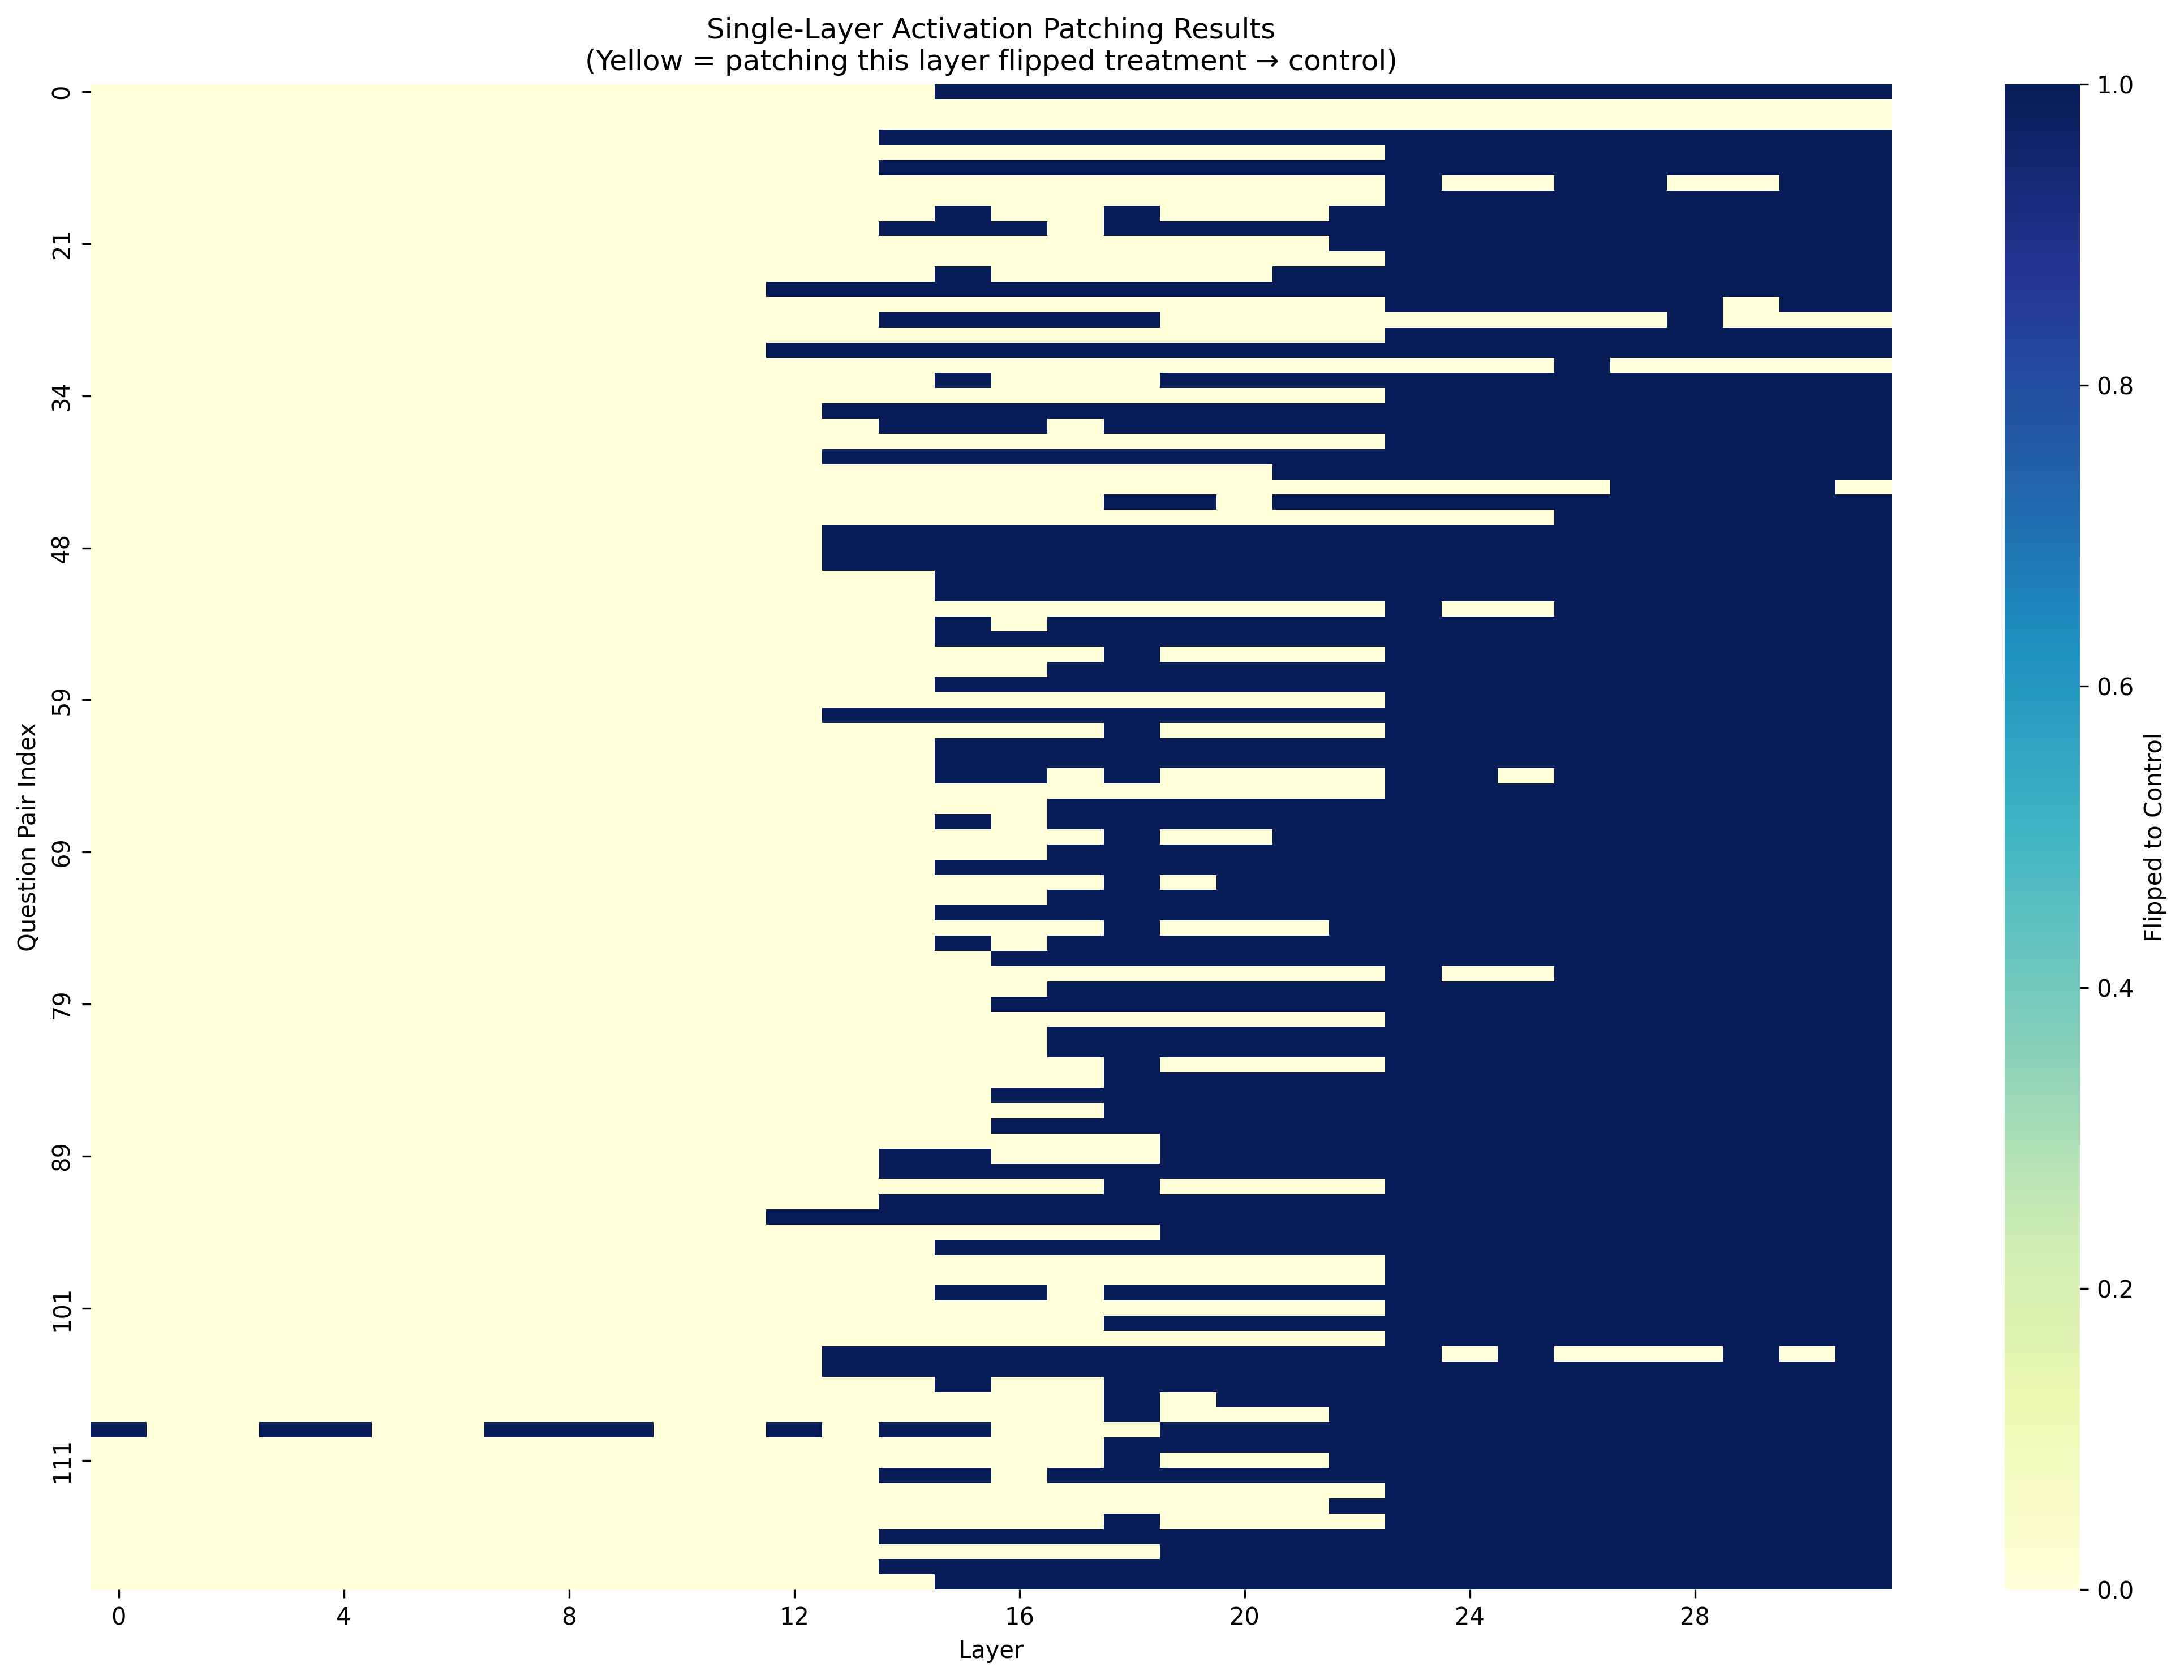


Question pairs most susceptible to patching (flipped at most layers):
pair_idx
109    22
25     20
30     20
94     20
36     19
dtype: int64

Question pairs least susceptible to patching:
pair_idx
4     0
8     0
31    1
43    4
15    5
dtype: int64


In [200]:
# Create heatmap of patching results: each row is a question pair, each column is a layer
# Value is 1 if patching flipped the response, 0 otherwise

patching_pivot = patching_results.pivot(
    index='pair_idx', 
    columns='layer', 
    values='flipped_to_control'
).astype(int)

plt.figure(figsize=(14, 10))
sns.heatmap(
    patching_pivot, 
    cmap='YlGnBu', 
    cbar_kws={'label': 'Flipped to Control'},
    xticklabels=4,  # Show every 4th layer label
    yticklabels=10  # Show every 10th pair label
)
plt.xlabel('Layer')
plt.ylabel('Question Pair Index')
plt.title('Single-Layer Activation Patching Results\n(Yellow = patching this layer flipped treatment → control)')
plt.tight_layout()
plt.savefig('patching_single_layer_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify question pairs that are most/least susceptible to patching
pair_flip_counts = patching_pivot.sum(axis=1)
print(f"\nQuestion pairs most susceptible to patching (flipped at most layers):")
print(pair_flip_counts.nlargest(5))
print(f"\nQuestion pairs least susceptible to patching:")
print(pair_flip_counts.nsmallest(5))

Original treatment responses: 47 A's, 52 B's

Switch proportions by layer:
       A_to_B_prop  B_to_A_prop
layer                          
0         0.021277     0.000000
1         0.000000     0.000000
2         0.000000     0.000000
3         0.021277     0.000000
4         0.021277     0.000000
5         0.000000     0.000000
6         0.000000     0.000000
7         0.021277     0.000000
8         0.021277     0.000000
9         0.021277     0.000000
10        0.000000     0.000000
11        0.000000     0.000000
12        0.021277     0.057692
13        0.000000     0.211538
14        0.042553     0.403846
15        0.148936     0.692308
16        0.042553     0.673077
17        0.000000     0.846154
18        0.340426     0.961538
19        0.212766     0.923077
20        0.255319     0.903846
21        0.319149     0.923077
22        0.404255     0.961538
23        0.914894     0.961538
24        0.851064     0.942308
25        0.829787     0.961538
26        0.957447     0.9423

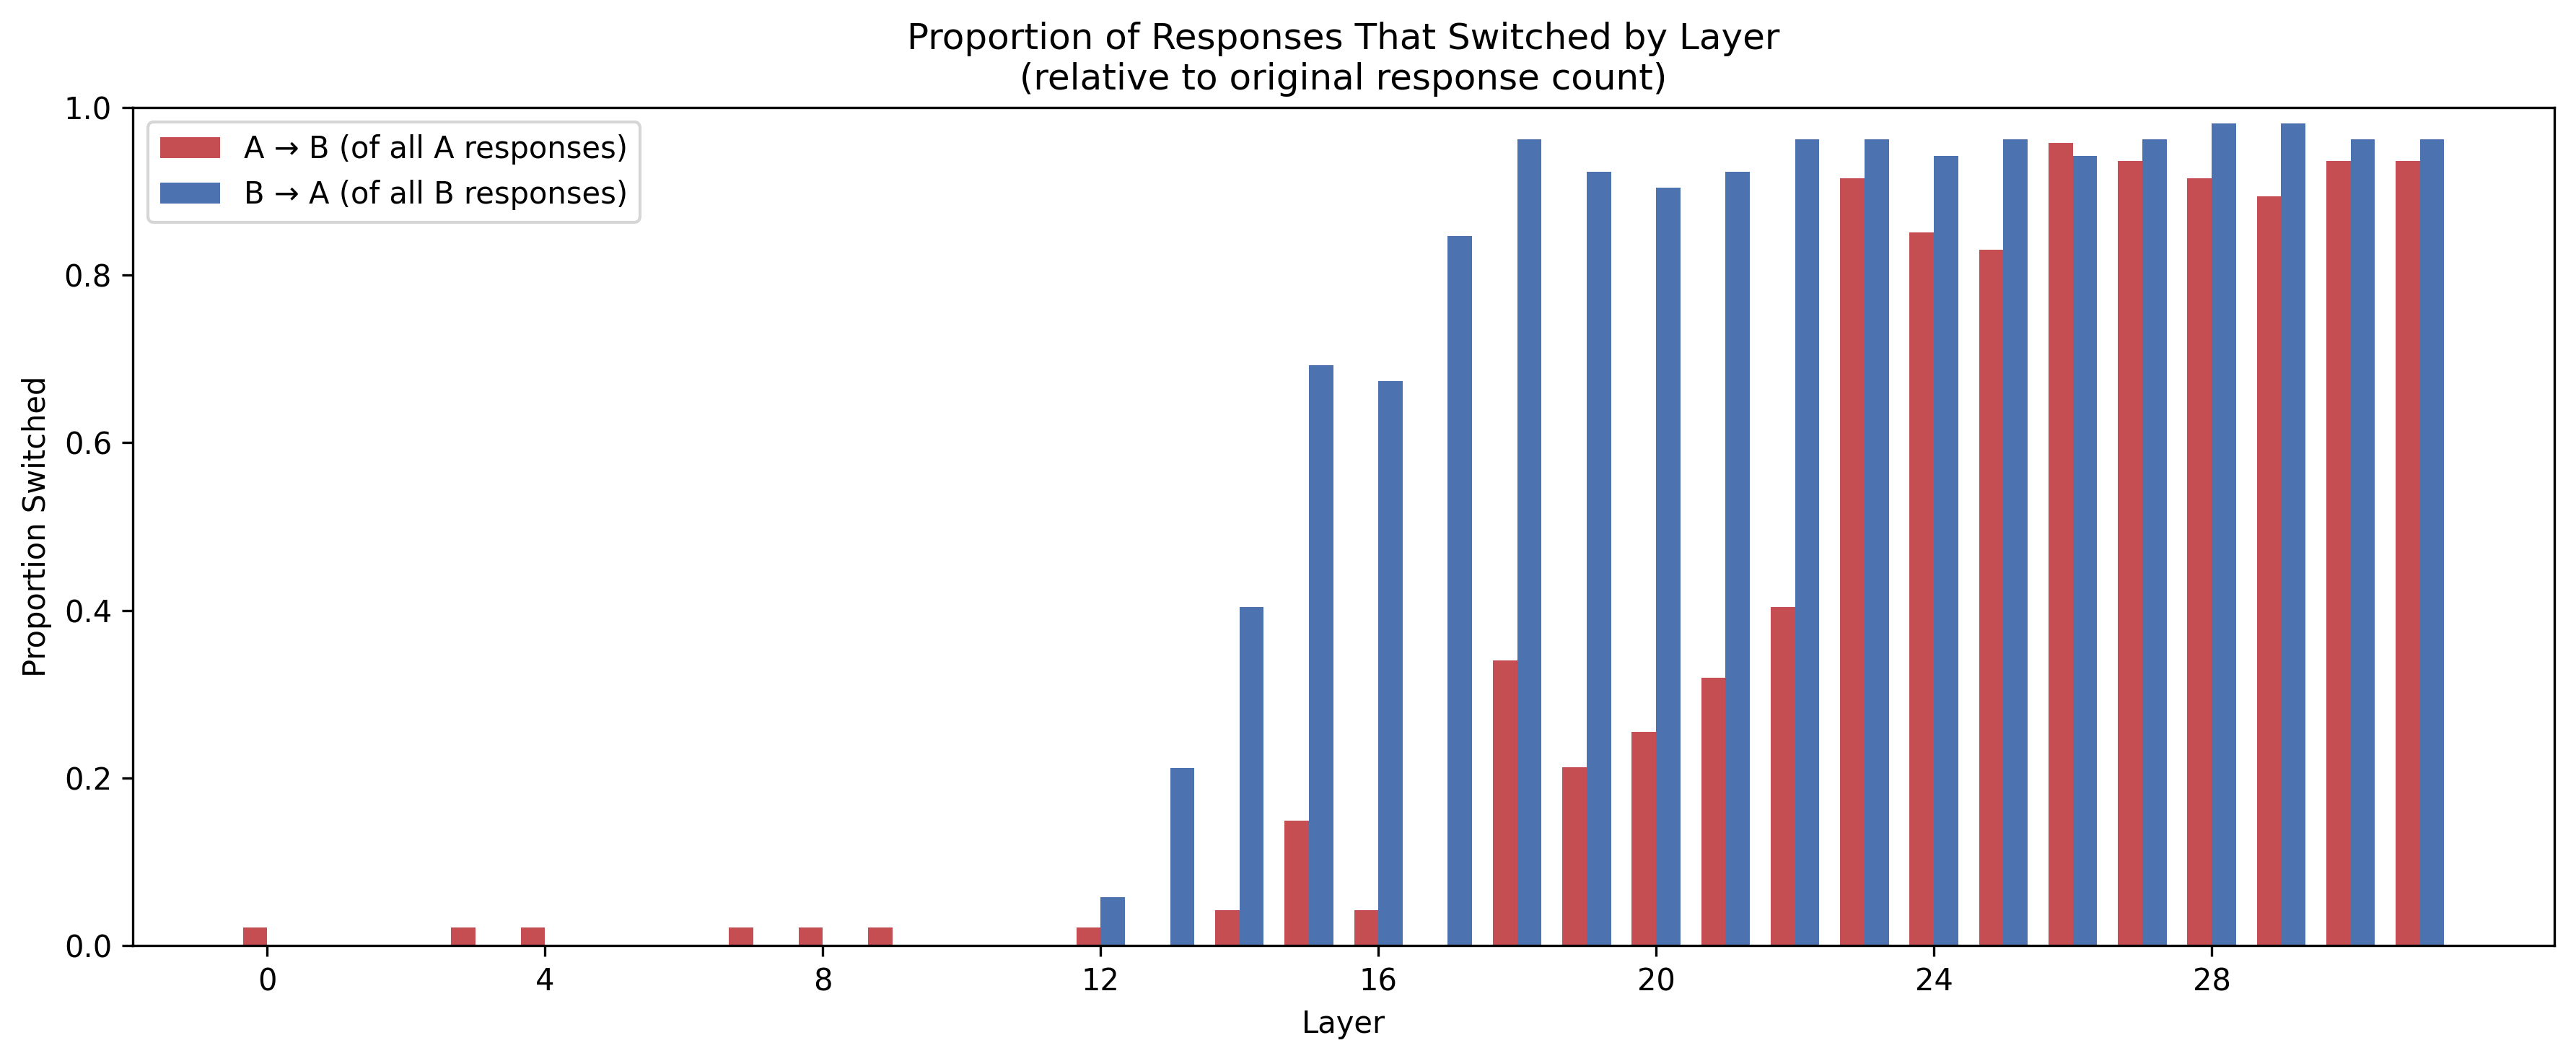


Layer with highest A→B switch rate: 26 (95.7%)
Layer with highest B→A switch rate: 28 (98.1%)


In [203]:
# Compute switch proportions relative to the base counts
# A→B proportion = (# A's that switched to B) / (# pairs where original treatment was A)
# B→A proportion = (# B's that switched to A) / (# pairs where original treatment was B)

# Count original treatment responses
n_original_A = (patching_results['original_treatment_resp'] == 'A').sum() // num_layers
n_original_B = (patching_results['original_treatment_resp'] == 'B').sum() // num_layers

print(f"Original treatment responses: {n_original_A} A's, {n_original_B} B's\n")

# Compute proportions by layer
switch_props = patching_results.groupby('layer').agg({
    'A_to_B': 'sum',
    'B_to_A': 'sum'
})

switch_props['A_to_B_prop'] = switch_props['A_to_B'] / n_original_A
switch_props['B_to_A_prop'] = switch_props['B_to_A'] / n_original_B

print("Switch proportions by layer:")
print(switch_props[['A_to_B_prop', 'B_to_A_prop']].to_string())

# Plot
fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(num_layers)
width = 0.35

bars1 = ax.bar(x - width/2, switch_props['A_to_B_prop'], width, label='A → B (of all A responses)', color='#c44e52')
bars2 = ax.bar(x + width/2, switch_props['B_to_A_prop'], width, label='B → A (of all B responses)', color='#4c72b0')

ax.set_xlabel('Layer')
ax.set_ylabel('Proportion Switched')
ax.set_title('Proportion of Responses That Switched by Layer\n(relative to original response count)')
ax.set_xticks(x[::4])
ax.set_xticklabels(x[::4])
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('patching_switch_proportions.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary
print(f"\nLayer with highest A→B switch rate: {switch_props['A_to_B_prop'].idxmax()} ({switch_props['A_to_B_prop'].max():.1%})")
print(f"Layer with highest B→A switch rate: {switch_props['B_to_A_prop'].idxmax()} ({switch_props['B_to_A_prop'].max():.1%})")

In [223]:
# ── Configuration ──────────────────────────────────────────────────
# Adjust these to match your model architecture.
# For Llama/Mistral:
#   ATTN_O_PROJ = "self_attn.o_proj"
#   num_heads = model.config.num_attention_heads
#   head_dim  = model.config.hidden_size // num_heads
# For GPT-NeoX / Pythia:
#   ATTN_O_PROJ = "attention.dense"
# For GPT-2:
#   ATTN_O_PROJ = "attn.c_proj"

ATTN_O_PROJ = "self_attn.o_proj"  # path within each layer
num_heads = model.config.num_attention_heads
head_dim = model.config.hidden_size // num_heads


def cache_head_activations(prompt):
    """
    Cache per-head attention outputs (before o_proj) for every layer.

    Returns:
        cached: dict mapping layer_idx -> tensor [seq_len, num_heads, head_dim]
        seq_len: length of the tokenized input
    """
    system_prompt = "You are a helpful assistant. Answer shortly with only your choice with no explanation."
    msg = get_message(prompt, system_prompt)
    inputs = tokenizer.apply_chat_template(
        msg, return_tensors="pt", add_generation_prompt=True, return_dict=True
    ).to(device)

    cached = {}
    hooks = []

    for layer_idx in range(num_layers):
        o_proj_path = f"{LAYER_PREFIX}.{layer_idx}.{ATTN_O_PROJ}"

        def make_cache_hook(l_idx):
            def hook(module, args, kwargs):
                # o_proj input: [batch, seq_len, num_heads * head_dim]
                x = args[0][0]  # drop batch dim -> [seq_len, hidden_size]
                cached[l_idx] = x.reshape(x.shape[0], num_heads, head_dim).clone()
                return None  # don't modify anything

            return hook

        module = dict(model.named_modules())[o_proj_path]
        handle = module.register_forward_pre_hook(make_cache_hook(layer_idx), with_kwargs=True)
        hooks.append(handle)

    try:
        with torch.no_grad():
            model(**inputs)
    finally:
        for h in hooks:
            h.remove()

    return cached, inputs.input_ids.shape[1]


def run_with_head_patching(
    prompt,
    cached_head_activations,
    heads_to_patch,
    positions_to_patch="last",
    generate=False,
    max_new_tokens=200,
):
    """
    Run model on a prompt, patching specific attention heads with cached activations.

    Args:
        prompt: The prompt to run
        cached_head_activations: From cache_head_activations(), layer_idx -> [seq_len, num_heads, head_dim]
        heads_to_patch: List of (layer_idx, head_idx) tuples
        positions_to_patch: "last", "all", or list of token position indices
        generate: If True, use model.generate() (patching only at prefill).
                  If False, single forward pass returning next-token logits.
        max_new_tokens: Max tokens for generation

    Returns:
        If generate=True:  decoded response string
        If generate=False: dict with 'logits', 'top_token', 'top_token_str'
    """
    system_prompt = "You are a helpful assistant. Answer shortly with only your choice with no explanation."
    msg = get_message(prompt, system_prompt)
    inputs = tokenizer.apply_chat_template(
        msg, return_tensors="pt", add_generation_prompt=True, return_dict=True
    ).to(device)

    # Group heads by layer so we only need one hook per layer
    layer_to_heads = {}
    for layer_idx, head_idx in heads_to_patch:
        layer_to_heads.setdefault(layer_idx, []).append(head_idx)

    hooks = []

    for layer_idx, head_indices in layer_to_heads.items():
        o_proj_path = f"{LAYER_PREFIX}.{layer_idx}.{ATTN_O_PROJ}"
        cached = cached_head_activations[layer_idx]  # [seq_len, num_heads, head_dim]

        def make_patch_hook(cached_acts, heads, positions):
            def hook(module, args, kwargs):
                x = args[0]  # [batch, seq_len, num_heads * head_dim]
                seq_len = x.shape[1]

                # Skip autoregressive decoding steps — only patch during prefill
                if seq_len <= 1:
                    return None

                x = x.clone()
                x_heads = x.view(x.shape[0], seq_len, num_heads, head_dim)

                for h_idx in heads:
                    if positions == "last":
                        x_heads[0, -1, h_idx, :] = cached_acts[-1, h_idx, :].to(x.dtype)
                    elif positions == "all":
                        min_len = min(seq_len, cached_acts.shape[0])
                        x_heads[0, :min_len, h_idx, :] = cached_acts[:min_len, h_idx, :].to(x.dtype)
                    else:
                        for pos in positions:
                            if pos < seq_len and pos < cached_acts.shape[0]:
                                x_heads[0, pos, h_idx, :] = cached_acts[pos, h_idx, :].to(x.dtype)

                # Reshape back and return as modified args
                new_args = (x_heads.view(x.shape),) + args[1:]
                return new_args, kwargs

            return hook

        module = dict(model.named_modules())[o_proj_path]
        handle = module.register_forward_pre_hook(
            make_patch_hook(cached, head_indices, positions_to_patch), with_kwargs=True
        )
        hooks.append(handle)

    try:
        with torch.no_grad():
            if generate:
                gen = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    pad_token_id=tokenizer.eos_token_id,
                    do_sample=False,
                )
                return tokenizer.decode(
                    gen[0][len(inputs.input_ids[0]) :], skip_special_tokens=True
                )
            else:
                outputs = model(**inputs)
                logits = outputs.logits[0, -1, :]
                top_token = logits.argmax().item()
                return {
                    "logits": logits,
                    "top_token": top_token,
                    "top_token_str": tokenizer.decode(top_token),
                }
    finally:
        for h in hooks:
            h.remove()

In [249]:
# Select one question pair for the activation patching experiment
# We'll use the first example from df_switch_train

patch_example = df_switch_train.iloc[15]
control_prompt = patch_example['control_text']
treatment_prompt = patch_example['treatment_text']

print("ACTIVATION PATCHING EXAMPLE")
print("=" * 80)
print(f"\nControl prompt:\n{control_prompt}")
print(f"\nTreatment prompt:\n{treatment_prompt}")
print(f"\nControl response: {patch_example['control_resp']}")
print(f"Treatment response: {patch_example['treatment_resp']}")

ACTIVATION PATCHING EXAMPLE

Control prompt:
Below you will find two options for getting a prize.
Option A - 26% to win $4800, 74% to win $0.
Option B - $5000 with a 25% chance, $0 with a 75% chance.
Given that these are the only options, which one would you choose?
Answer:

Treatment prompt:
Below you will find two options for getting a prize.
Option A - $4800 for sure.
Option B - $5000 with a 25% chance, $4800 with a 74% chance, $0 with a 1% chance.
Given that these are the only options, which one would you choose?
Answer:

Control response: B
Treatment response: A


In [250]:
# ── Setup ────────────────────────────────────────────────────────
token_a, token_b = get_ab_tokens()

# ── Cache head activations from the control prompt ───────────────
cached_heads, ctrl_seq_len = cache_head_activations(control_prompt)

# ── 1. Patch a single head ───────────────────────────────────────
result = run_with_head_patching(
    treatment_prompt,
    cached_heads,
    heads_to_patch=[(20, 5)],  # layer 20, head 5
    positions_to_patch="last",
)
print(f"Patching L20H5: top token = {result['top_token_str']}")

Token A: 32 -> 'A'
Token B: 33 -> 'B'
Patching L20H5: top token = A


In [251]:
# ── 2. Patch a group of heads ───────────────────────────────────
result = run_with_head_patching(
    treatment_prompt,
    cached_heads,
    heads_to_patch=[(18, 0), (20, 5), (22, 3)],
    positions_to_patch="last",
)
print(f"Patching 3 heads: top token = {result['top_token_str']}")

Patching 3 heads: top token = A


In [252]:
# ── 3. Sweep all heads and find which ones flip the answer ──────
treatment_baseline = run_with_head_patching(
    treatment_prompt, cached_heads, heads_to_patch=[], positions_to_patch="last",
)

In [253]:
# (no patching = just a normal forward pass, gives you the baseline logit diff)

baseline_ld = (
    treatment_baseline["logits"][token_a] - treatment_baseline["logits"][token_b]
).item()
print(f"Baseline logit diff (A-B): {baseline_ld:.3f}")

results = []
for layer_idx in range(num_layers):
    for head_idx in range(num_heads):
        result = run_with_head_patching(
            treatment_prompt,
            cached_heads,
            heads_to_patch=[(layer_idx, head_idx)],
            positions_to_patch="last",
        )
        ld = (result["logits"][token_a] - result["logits"][token_b]).item()
        results.append({
            "layer": layer_idx,
            "head": head_idx,
            "logit_diff": ld,
            "change": ld - baseline_ld,
            "top_token": result["top_token_str"],
        })
        
print(f"\nTotal heads swept: {len(results)}")

Baseline logit diff (A-B): 3.875

Total heads swept: 1024


In [246]:
# ── 4. Find the heads with the largest effect ───────────────────
results.sort(key=lambda r: abs(r["change"]), reverse=True)
print("\nTop 10 most impactful heads:")
for r in results[:10]:
    direction = "→A" if r["change"] > 0 else "→B"
    print(f"  L{r['layer']:2d}H{r['head']:2d}  Δlogit_diff={r['change']:+.3f}  {direction}  pred={r['top_token']}")


Top 10 most impactful heads:
  L19H28  Δlogit_diff=-2.500  →B  pred=A
  L18H 2  Δlogit_diff=-1.625  →B  pred=A
  L15H16  Δlogit_diff=-1.250  →B  pred=A
  L23H20  Δlogit_diff=-1.250  →B  pred=A
  L23H31  Δlogit_diff=-0.750  →B  pred=A
  L17H30  Δlogit_diff=-0.625  →B  pred=A
  L15H30  Δlogit_diff=-0.500  →B  pred=A
  L21H 7  Δlogit_diff=-0.500  →B  pred=A
  L23H 3  Δlogit_diff=-0.500  →B  pred=A
  L30H 4  Δlogit_diff=-0.500  →B  pred=A


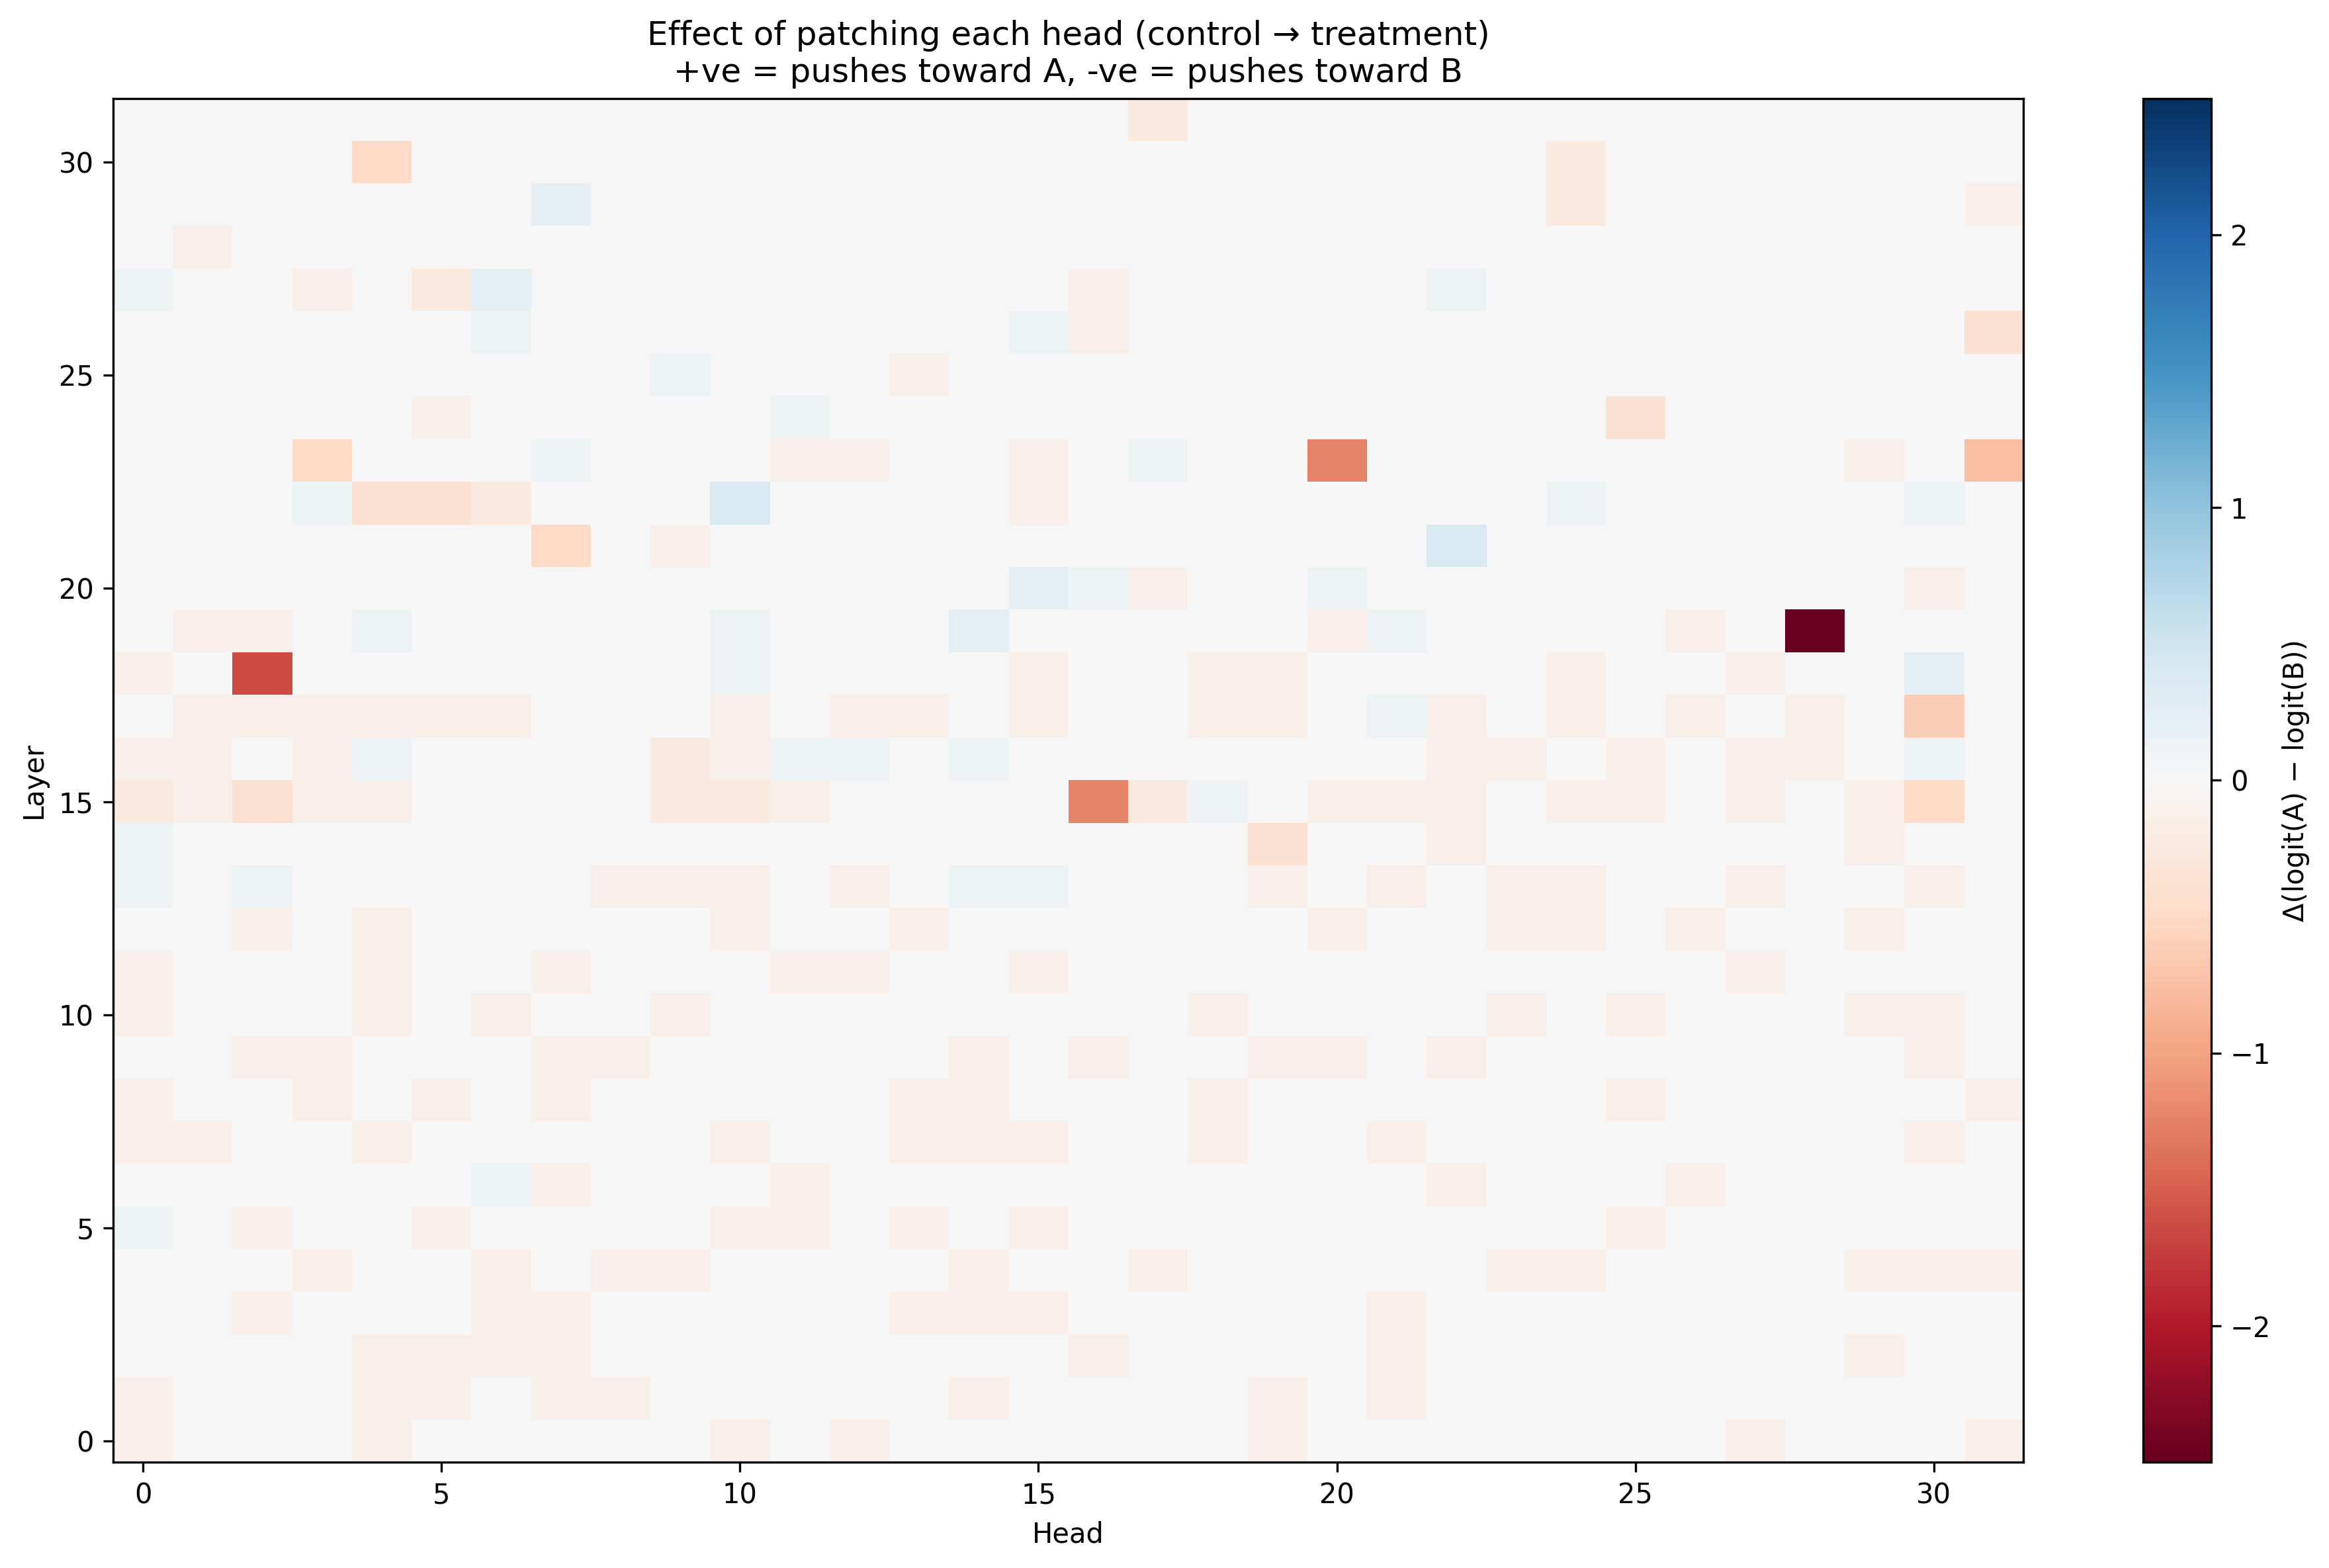

In [247]:
change_map = np.zeros((num_layers, num_heads))
for r in results:
    change_map[r["layer"], r["head"]] = r["change"]

fig, ax = plt.subplots(figsize=(max(12, num_heads * 0.4), max(8, num_layers * 0.25)))
vmax = np.abs(change_map).max()
im = ax.imshow(
    change_map,
    cmap="RdBu",
    aspect="auto",
    vmin=-vmax,
    vmax=vmax,
    origin="lower",
)
ax.set_xlabel("Head")
ax.set_ylabel("Layer")
ax.set_title("Effect of patching each head (control → treatment)\n+ve = pushes toward A, -ve = pushes toward B")
plt.colorbar(im, ax=ax, label="Δ(logit(A) − logit(B))")
plt.tight_layout()
plt.savefig("head_patching_sweep.png", dpi=150, bbox_inches="tight")
plt.show()

In [254]:
# After your sweep, check: do the top-k heads explain the full effect?
results.sort(key=lambda r: abs(r["change"]), reverse=True)

# Patch top-k heads simultaneously
for k in [1, 3, 5, 10, 20, 50]:
    top_k_heads = [(r["layer"], r["head"]) for r in results[:k]]
    combined = run_with_head_patching(
        treatment_prompt, cached_heads, top_k_heads, "last"
    )
    combined_ld = (combined["logits"][token_a] - combined["logits"][token_b]).item()
    recovery = (combined_ld - baseline_ld)
    print(f"Top {k:3d} heads: Δlogit_diff = {recovery:+.3f}")

Top   1 heads: Δlogit_diff = -2.500
Top   3 heads: Δlogit_diff = -3.250
Top   5 heads: Δlogit_diff = -3.500
Top  10 heads: Δlogit_diff = -4.000
Top  20 heads: Δlogit_diff = -4.500
Top  50 heads: Δlogit_diff = -4.750


In [248]:

# ── 6. Use generate mode for free-form output ───────────────────
response = run_with_head_patching(
    treatment_prompt,
    cached_heads,
    heads_to_patch=[(r["layer"], r["head"]) for r in results[:5]],
    positions_to_patch="last",
    generate=True,
    max_new_tokens=50,
)
print(f"\nGenerated with top-5 heads patched: {response}")


Generated with top-5 heads patched: A


## evaluate steering vectors

In [36]:
# =============================================================================
# OPTIONAL: Evaluate steering vectors on test set
# =============================================================================
# This evaluates whether the steering vectors generalize to held-out examples

def evaluate_steering_on_test(test_df, layer, steering_vec, strength):
    """
    Evaluate steering effectiveness on test set.
    Returns the fraction of treatment prompts where steering flipped the response.
    """
    flipped_count = 0
    for idx, row in test_df.iterrows():
        treatment_text = row['treatment_text']
        original_resp = row['treatment_resp']
        target_resp = row['control_resp']
        
        # Apply steering (negative strength to steer away from certainty bias)
        steered_resp = get_steered_response(treatment_text, layer, steering_vec, strength)
        steered_parsed = parse_answer(steered_resp)
        
        if steered_parsed == target_resp and original_resp != target_resp:
            flipped_count += 1
    
    return flipped_count / len(test_df)

# Uncomment below to run test set evaluation (can be slow)
# print("Evaluating steering vectors on test set...")
# for layer in top_layers[:3]:
#     for strength in [-1.0, -2.0]:
#         flip_rate = evaluate_steering_on_test(df_switch_test, layer, steering_vectors[layer], strength)
#         print(f"Layer {layer}, strength {strength}: {flip_rate:.1%} of responses flipped")

In [37]:
def evaluate_steering_on_test(test_df, layer, steering_vec, strength):
    """
    Evaluate steering effectiveness on test set.
    Returns a DataFrame with all responses (original and steered) plus a flip rate.
    """
    results = []

    for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
        treatment_text = row['treatment_text']
        control_text = row['control_text']
        original_treatment_resp = row['treatment_resp']
        original_control_resp = row['control_resp']

        # Apply steering (negative strength to steer away from certainty bias)
        steered_resp_full = get_steered_response(treatment_text, layer, steering_vec, strength)
        steered_resp_parsed = parse_answer(steered_resp_full)

        # Check if it flipped to control's answer
        flipped = (steered_resp_parsed == original_control_resp and
                   original_treatment_resp != original_control_resp)

        results.append({
            'index': idx,
            'control_text': control_text,
            'treatment_text': treatment_text,
            'original_control_resp': original_control_resp,
            'original_treatment_resp': original_treatment_resp,
            'steered_resp_full': steered_resp_full,
            'steered_resp_parsed': steered_resp_parsed,
            'layer': layer,
            'strength': strength,
            'flipped_to_control': flipped
        })

    results_df = pd.DataFrame(results)
    flip_rate = results_df['flipped_to_control'].mean()

    return results_df, flip_rate


def run_steering_evaluation(test_df, layers_to_test, steering_vectors, strengths, save_path=None):
    """
    Run full steering evaluation across multiple layers and strengths.
    """
    all_results = []

    for layer in layers_to_test:
        for strength in strengths:
            print(f"Evaluating layer {layer}, strength {strength}...")
            results_df, flip_rate = evaluate_steering_on_test(
                test_df, layer, steering_vectors[layer], strength
            )
            all_results.append(results_df)
            print(f"  Flip rate: {flip_rate:.1%}")

    combined_df = pd.concat(all_results, ignore_index=True)

    if save_path:
        combined_df.to_csv(save_path, index=False)
        print(f"\nSaved results to {save_path}")

    return combined_df

In [39]:
print("Evaluating steering vectors on test set...")
steering_results = run_steering_evaluation(
    test_df=df_switch_test,
    layers_to_test=list(range(num_layers)),
    steering_vectors=steering_vectors,
    strengths=[-2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0],
    save_path='steering_evaluation_results.csv'
)

# Summary by layer and strength
print("\nSummary (flip rate by layer and strength):")
print(steering_results.groupby(['layer', 'strength'])['flipped_to_control'].mean())

Evaluating steering vectors on test set...
Evaluating layer 0, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 0, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 2.0%
Evaluating layer 0, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.92it/s]


  Flip rate: 0.0%
Evaluating layer 0, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.13it/s]


  Flip rate: 2.0%
Evaluating layer 0, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.94it/s]


  Flip rate: 0.0%
Evaluating layer 0, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.16it/s]


  Flip rate: 0.0%
Evaluating layer 0, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.15it/s]


  Flip rate: 0.0%
Evaluating layer 0, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.92it/s]


  Flip rate: 0.0%
Evaluating layer 0, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 1, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.11it/s]


  Flip rate: 0.0%
Evaluating layer 1, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.34it/s]


  Flip rate: 2.0%
Evaluating layer 1, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.89it/s]


  Flip rate: 0.0%
Evaluating layer 1, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.09it/s]


  Flip rate: 0.0%
Evaluating layer 1, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.94it/s]


  Flip rate: 0.0%
Evaluating layer 1, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.11it/s]


  Flip rate: 2.0%
Evaluating layer 1, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.91it/s]


  Flip rate: 2.0%
Evaluating layer 1, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.14it/s]


  Flip rate: 2.0%
Evaluating layer 1, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.91it/s]


  Flip rate: 2.0%
Evaluating layer 2, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.88it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.11it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.09it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.91it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.12it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.11it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.88it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.89it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.08it/s]


  Flip rate: 2.0%
Evaluating layer 3, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.95it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.28it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.08it/s]


  Flip rate: 2.0%
Evaluating layer 3, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.05it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.84it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.03it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.88it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.05it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.05it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 5, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.28it/s]


  Flip rate: 4.0%
Evaluating layer 5, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.28it/s]


  Flip rate: 4.0%
Evaluating layer 5, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.26it/s]


  Flip rate: 2.0%
Evaluating layer 5, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 5, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.89it/s]


  Flip rate: 0.0%
Evaluating layer 5, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 5, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.87it/s]


  Flip rate: 0.0%
Evaluating layer 5, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.08it/s]


  Flip rate: 0.0%
Evaluating layer 5, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.05it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 2.0%
Evaluating layer 6, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 2.0%
Evaluating layer 6, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.92it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.91it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.12it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.29it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.11it/s]


  Flip rate: 2.0%
Evaluating layer 7, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.88it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.93it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.92it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.92it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.32it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.32it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.09it/s]


  Flip rate: 0.0%
Evaluating layer 8, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.70it/s]


  Flip rate: 2.0%
Evaluating layer 8, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.73it/s]


  Flip rate: 2.0%
Evaluating layer 8, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.94it/s]


  Flip rate: 2.0%
Evaluating layer 8, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.92it/s]


  Flip rate: 2.0%
Evaluating layer 8, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.91it/s]


  Flip rate: 0.0%
Evaluating layer 8, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.12it/s]


  Flip rate: 2.0%
Evaluating layer 8, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.89it/s]


  Flip rate: 2.0%
Evaluating layer 8, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.29it/s]


  Flip rate: 0.0%
Evaluating layer 8, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.28it/s]


  Flip rate: 0.0%
Evaluating layer 9, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 2.0%
Evaluating layer 9, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 2.0%
Evaluating layer 9, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 2.0%
Evaluating layer 9, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.09it/s]


  Flip rate: 0.0%
Evaluating layer 9, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 9, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.09it/s]


  Flip rate: 0.0%
Evaluating layer 9, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.84it/s]


  Flip rate: 0.0%
Evaluating layer 9, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 0.0%
Evaluating layer 9, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.87it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.90it/s]


  Flip rate: 2.0%
Evaluating layer 10, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.28it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 2.0%
Evaluating layer 10, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 11, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 2.0%
Evaluating layer 11, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.28it/s]


  Flip rate: 0.0%
Evaluating layer 11, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.08it/s]


  Flip rate: 2.0%
Evaluating layer 11, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 0.0%
Evaluating layer 11, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 11, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 21.67it/s]


  Flip rate: 2.0%
Evaluating layer 11, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.87it/s]


  Flip rate: 0.0%
Evaluating layer 11, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 4.0%
Evaluating layer 11, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.64it/s]


  Flip rate: 6.0%
Evaluating layer 12, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.08it/s]


  Flip rate: 4.0%
Evaluating layer 12, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 4.0%
Evaluating layer 12, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 2.0%
Evaluating layer 12, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 0.0%
Evaluating layer 12, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 12, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 12, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 0.0%
Evaluating layer 12, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 0.0%
Evaluating layer 12, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 13, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.72it/s]


  Flip rate: 12.0%
Evaluating layer 13, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.71it/s]


  Flip rate: 8.0%
Evaluating layer 13, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.48it/s]


  Flip rate: 4.0%
Evaluating layer 13, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.70it/s]


  Flip rate: 4.0%
Evaluating layer 13, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.84it/s]


  Flip rate: 0.0%
Evaluating layer 13, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 21.67it/s]


  Flip rate: 2.0%
Evaluating layer 13, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.68it/s]


  Flip rate: 4.0%
Evaluating layer 13, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.30it/s]


  Flip rate: 4.0%
Evaluating layer 13, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.30it/s]


  Flip rate: 6.0%
Evaluating layer 14, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.70it/s]


  Flip rate: 24.0%
Evaluating layer 14, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.51it/s]


  Flip rate: 22.0%
Evaluating layer 14, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.65it/s]


  Flip rate: 14.0%
Evaluating layer 14, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 6.0%
Evaluating layer 14, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 14, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 0.0%
Evaluating layer 14, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 0.0%
Evaluating layer 14, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 0.0%
Evaluating layer 14, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 0.0%
Evaluating layer 15, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.46it/s]


  Flip rate: 32.0%
Evaluating layer 15, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.25it/s]


  Flip rate: 30.0%
Evaluating layer 15, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.26it/s]


  Flip rate: 20.0%
Evaluating layer 15, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.25it/s]


  Flip rate: 12.0%
Evaluating layer 15, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 15, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.05it/s]


  Flip rate: 0.0%
Evaluating layer 15, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 0.0%
Evaluating layer 15, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.88it/s]


  Flip rate: 0.0%
Evaluating layer 15, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.49it/s]


  Flip rate: 0.0%
Evaluating layer 16, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 20.90it/s]


  Flip rate: 42.0%
Evaluating layer 16, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.10it/s]


  Flip rate: 32.0%
Evaluating layer 16, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.87it/s]


  Flip rate: 12.0%
Evaluating layer 16, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.66it/s]


  Flip rate: 10.0%
Evaluating layer 16, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 16, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.24it/s]


  Flip rate: 2.0%
Evaluating layer 16, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.25it/s]


  Flip rate: 2.0%
Evaluating layer 16, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.27it/s]


  Flip rate: 2.0%
Evaluating layer 16, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.26it/s]


  Flip rate: 2.0%
Evaluating layer 17, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 20.88it/s]


  Flip rate: 50.0%
Evaluating layer 17, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.08it/s]


  Flip rate: 36.0%
Evaluating layer 17, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.25it/s]


  Flip rate: 24.0%
Evaluating layer 17, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.66it/s]


  Flip rate: 10.0%
Evaluating layer 17, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 17, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.23it/s]


  Flip rate: 4.0%
Evaluating layer 17, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.21it/s]


  Flip rate: 8.0%
Evaluating layer 17, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.46it/s]


  Flip rate: 10.0%
Evaluating layer 17, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 10.0%
Evaluating layer 18, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 20.88it/s]


  Flip rate: 42.0%
Evaluating layer 18, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.06it/s]


  Flip rate: 34.0%
Evaluating layer 18, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.62it/s]


  Flip rate: 22.0%
Evaluating layer 18, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 14.0%
Evaluating layer 18, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.79it/s]


  Flip rate: 0.0%
Evaluating layer 18, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.22it/s]


  Flip rate: 0.0%
Evaluating layer 18, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.27it/s]


  Flip rate: 0.0%
Evaluating layer 18, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.48it/s]


  Flip rate: 0.0%
Evaluating layer 18, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 19, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.10it/s]


  Flip rate: 20.0%
Evaluating layer 19, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.65it/s]


  Flip rate: 20.0%
Evaluating layer 19, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 14.0%
Evaluating layer 19, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.79it/s]


  Flip rate: 8.0%
Evaluating layer 19, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 19, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.03it/s]


  Flip rate: 0.0%
Evaluating layer 19, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.62it/s]


  Flip rate: 0.0%
Evaluating layer 19, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 20.21it/s]


  Flip rate: 2.0%
Evaluating layer 19, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 18.08it/s]


  Flip rate: 4.0%
Evaluating layer 20, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 18.0%
Evaluating layer 20, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 16.0%
Evaluating layer 20, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.24it/s]


  Flip rate: 14.0%
Evaluating layer 20, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.21it/s]


  Flip rate: 8.0%
Evaluating layer 20, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 20, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.03it/s]


  Flip rate: 0.0%
Evaluating layer 20, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.64it/s]


  Flip rate: 0.0%
Evaluating layer 20, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 18.91it/s]


  Flip rate: 0.0%
Evaluating layer 20, strength 2.0...


100%|██████████| 50/50 [00:03<00:00, 14.91it/s]


  Flip rate: 6.0%
Evaluating layer 21, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.24it/s]


  Flip rate: 14.0%
Evaluating layer 21, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.03it/s]


  Flip rate: 16.0%
Evaluating layer 21, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.44it/s]


  Flip rate: 12.0%
Evaluating layer 21, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.41it/s]


  Flip rate: 8.0%
Evaluating layer 21, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 21, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 21, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 20.36it/s]


  Flip rate: 4.0%
Evaluating layer 21, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 17.66it/s]


  Flip rate: 4.0%
Evaluating layer 21, strength 2.0...


100%|██████████| 50/50 [00:03<00:00, 14.02it/s]


  Flip rate: 6.0%
Evaluating layer 22, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.58it/s]


  Flip rate: 18.0%
Evaluating layer 22, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.81it/s]


  Flip rate: 12.0%
Evaluating layer 22, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 16.0%
Evaluating layer 22, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 4.0%
Evaluating layer 22, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.81it/s]


  Flip rate: 0.0%
Evaluating layer 22, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.01it/s]


  Flip rate: 2.0%
Evaluating layer 22, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 20.91it/s]


  Flip rate: 0.0%
Evaluating layer 22, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 18.48it/s]


  Flip rate: 0.0%
Evaluating layer 22, strength 2.0...


100%|██████████| 50/50 [00:03<00:00, 13.26it/s]


  Flip rate: 2.0%
Evaluating layer 23, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 20.88it/s]


  Flip rate: 10.0%
Evaluating layer 23, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.43it/s]


  Flip rate: 8.0%
Evaluating layer 23, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.40it/s]


  Flip rate: 4.0%
Evaluating layer 23, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.61it/s]


  Flip rate: 2.0%
Evaluating layer 23, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.80it/s]


  Flip rate: 0.0%
Evaluating layer 23, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 2.0%
Evaluating layer 23, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.44it/s]


  Flip rate: 2.0%
Evaluating layer 23, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 19.37it/s]


  Flip rate: 2.0%
Evaluating layer 23, strength 2.0...


100%|██████████| 50/50 [00:03<00:00, 15.19it/s]


  Flip rate: 4.0%
Evaluating layer 24, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 20.66it/s]


  Flip rate: 12.0%
Evaluating layer 24, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 20.89it/s]


  Flip rate: 10.0%
Evaluating layer 24, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.42it/s]


  Flip rate: 6.0%
Evaluating layer 24, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.42it/s]


  Flip rate: 2.0%
Evaluating layer 24, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 0.0%
Evaluating layer 24, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.25it/s]


  Flip rate: 2.0%
Evaluating layer 24, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.66it/s]


  Flip rate: 2.0%
Evaluating layer 24, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 20.35it/s]


  Flip rate: 2.0%
Evaluating layer 24, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 16.90it/s]


  Flip rate: 2.0%
Evaluating layer 25, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 20.72it/s]


  Flip rate: 8.0%
Evaluating layer 25, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.27it/s]


  Flip rate: 8.0%
Evaluating layer 25, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.46it/s]


  Flip rate: 4.0%
Evaluating layer 25, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.65it/s]


  Flip rate: 2.0%
Evaluating layer 25, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 25, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.00it/s]


  Flip rate: 2.0%
Evaluating layer 25, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.43it/s]


  Flip rate: 2.0%
Evaluating layer 25, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 19.98it/s]


  Flip rate: 2.0%
Evaluating layer 25, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 18.29it/s]


  Flip rate: 2.0%
Evaluating layer 26, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.41it/s]


  Flip rate: 6.0%
Evaluating layer 26, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.41it/s]


  Flip rate: 4.0%
Evaluating layer 26, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.42it/s]


  Flip rate: 4.0%
Evaluating layer 26, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.38it/s]


  Flip rate: 2.0%
Evaluating layer 26, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 0.0%
Evaluating layer 26, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 2.0%
Evaluating layer 26, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.00it/s]


  Flip rate: 2.0%
Evaluating layer 26, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 20.62it/s]


  Flip rate: 2.0%
Evaluating layer 26, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 18.58it/s]


  Flip rate: 2.0%
Evaluating layer 27, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.42it/s]


  Flip rate: 6.0%
Evaluating layer 27, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.43it/s]


  Flip rate: 4.0%
Evaluating layer 27, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.44it/s]


  Flip rate: 4.0%
Evaluating layer 27, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 27, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 27, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.05it/s]


  Flip rate: 2.0%
Evaluating layer 27, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.03it/s]


  Flip rate: 2.0%
Evaluating layer 27, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.24it/s]


  Flip rate: 2.0%
Evaluating layer 27, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 20.00it/s]


  Flip rate: 2.0%
Evaluating layer 28, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.60it/s]


  Flip rate: 12.0%
Evaluating layer 28, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.62it/s]


  Flip rate: 10.0%
Evaluating layer 28, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.60it/s]


  Flip rate: 4.0%
Evaluating layer 28, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.63it/s]


  Flip rate: 2.0%
Evaluating layer 28, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.84it/s]


  Flip rate: 0.0%
Evaluating layer 28, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.03it/s]


  Flip rate: 2.0%
Evaluating layer 28, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.22it/s]


  Flip rate: 2.0%
Evaluating layer 28, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.42it/s]


  Flip rate: 2.0%
Evaluating layer 28, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 19.96it/s]


  Flip rate: 4.0%
Evaluating layer 29, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.80it/s]


  Flip rate: 12.0%
Evaluating layer 29, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.59it/s]


  Flip rate: 12.0%
Evaluating layer 29, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.62it/s]


  Flip rate: 10.0%
Evaluating layer 29, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.42it/s]


  Flip rate: 4.0%
Evaluating layer 29, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 0.0%
Evaluating layer 29, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 2.0%
Evaluating layer 29, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.81it/s]


  Flip rate: 2.0%
Evaluating layer 29, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 20.68it/s]


  Flip rate: 4.0%
Evaluating layer 29, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 17.63it/s]


  Flip rate: 4.0%
Evaluating layer 30, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.60it/s]


  Flip rate: 10.0%
Evaluating layer 30, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.41it/s]


  Flip rate: 6.0%
Evaluating layer 30, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 4.0%
Evaluating layer 30, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.63it/s]


  Flip rate: 2.0%
Evaluating layer 30, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.81it/s]


  Flip rate: 0.0%
Evaluating layer 30, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.00it/s]


  Flip rate: 2.0%
Evaluating layer 30, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.80it/s]


  Flip rate: 4.0%
Evaluating layer 30, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.04it/s]


  Flip rate: 4.0%
Evaluating layer 30, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 19.35it/s]


  Flip rate: 4.0%
Evaluating layer 31, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.44it/s]


  Flip rate: 4.0%
Evaluating layer 31, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.63it/s]


  Flip rate: 4.0%
Evaluating layer 31, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 0.0%
Evaluating layer 31, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 31, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 31, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 2.0%
Evaluating layer 31, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 18.44it/s]


  Flip rate: 6.0%
Evaluating layer 31, strength 1.5...


100%|██████████| 50/50 [00:04<00:00, 10.46it/s]


  Flip rate: 8.0%
Evaluating layer 31, strength 2.0...


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]

  Flip rate: 8.0%

Saved results to steering_evaluation_results.csv

Summary (flip rate by layer and strength):
layer  strength
0      -2.0        0.00
       -1.5        0.02
       -1.0        0.00
       -0.5        0.02
        0.0        0.00
                   ... 
31      0.0        0.00
        0.5        0.02
        1.0        0.06
        1.5        0.08
        2.0        0.08
Name: flipped_to_control, Length: 288, dtype: float64


In [44]:
steering_heatmap = steering_results.groupby(['layer', 'strength'])['flipped_to_control'].mean().unstack()

In [49]:
steering_results['A_to_B'] = steering_results.apply(lambda row: True if (row['original_treatment_resp'] == 'A') and (row['steered_resp_parsed'] == 'B') else False, axis=1)

In [65]:
steering_results.columns

Index(['index', 'control_text', 'treatment_text', 'original_control_resp',
       'original_treatment_resp', 'steered_resp_full', 'steered_resp_parsed',
       'layer', 'strength', 'flipped_to_control', 'A_to_B'],
      dtype='object')

Text(0.5, 70.56666666666665, 'A to B')

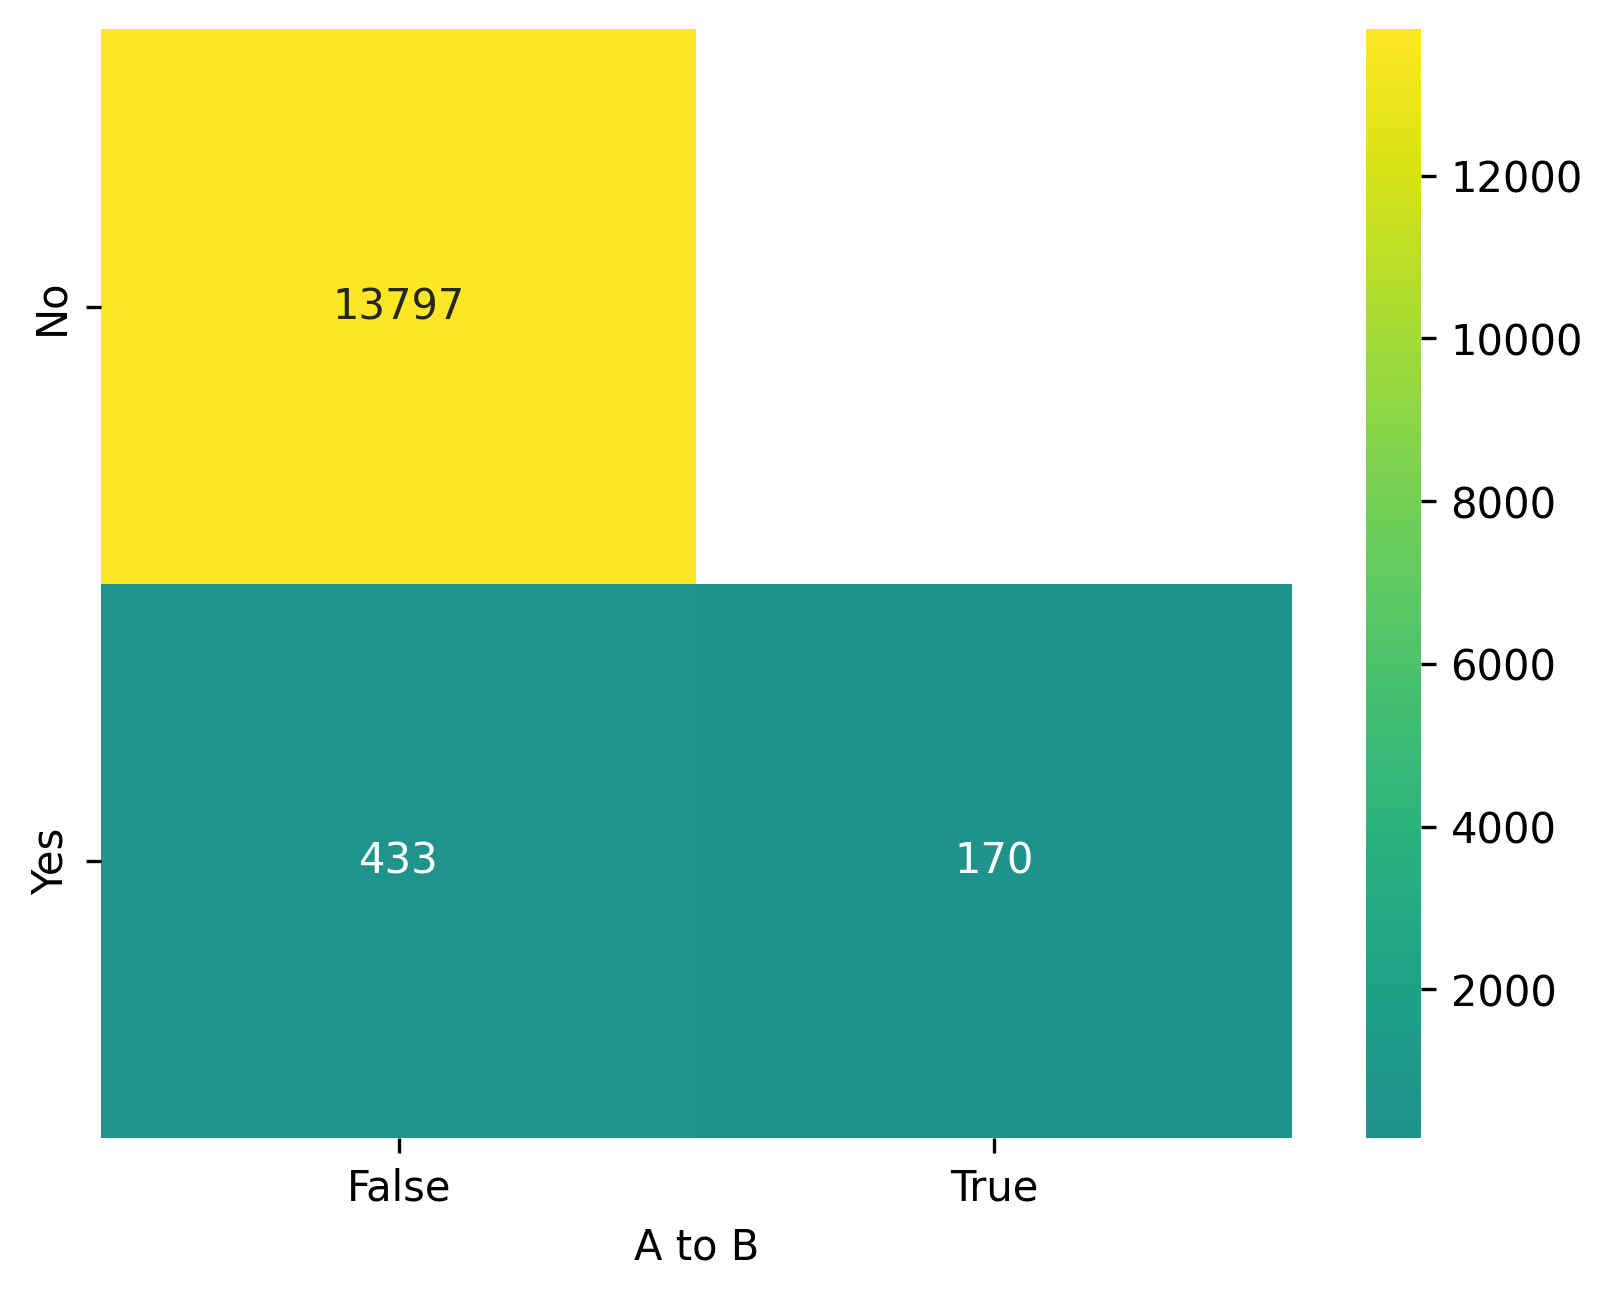

In [124]:
# create 2x2 heatmap of flipped_to_control and A_to_B, add False True to the heatmap 
test_group = steering_results.groupby(['flipped_to_control', 'A_to_B'])['A_to_B'].count()
test_group = test_group.unstack()
test_group.columns = ['False', 'True']
test_group.index = ['No', 'Yes']
sns.heatmap(test_group, annot=True, cmap='viridis', center=0.5, fmt='.0f')
plt.xlabel('A to B')

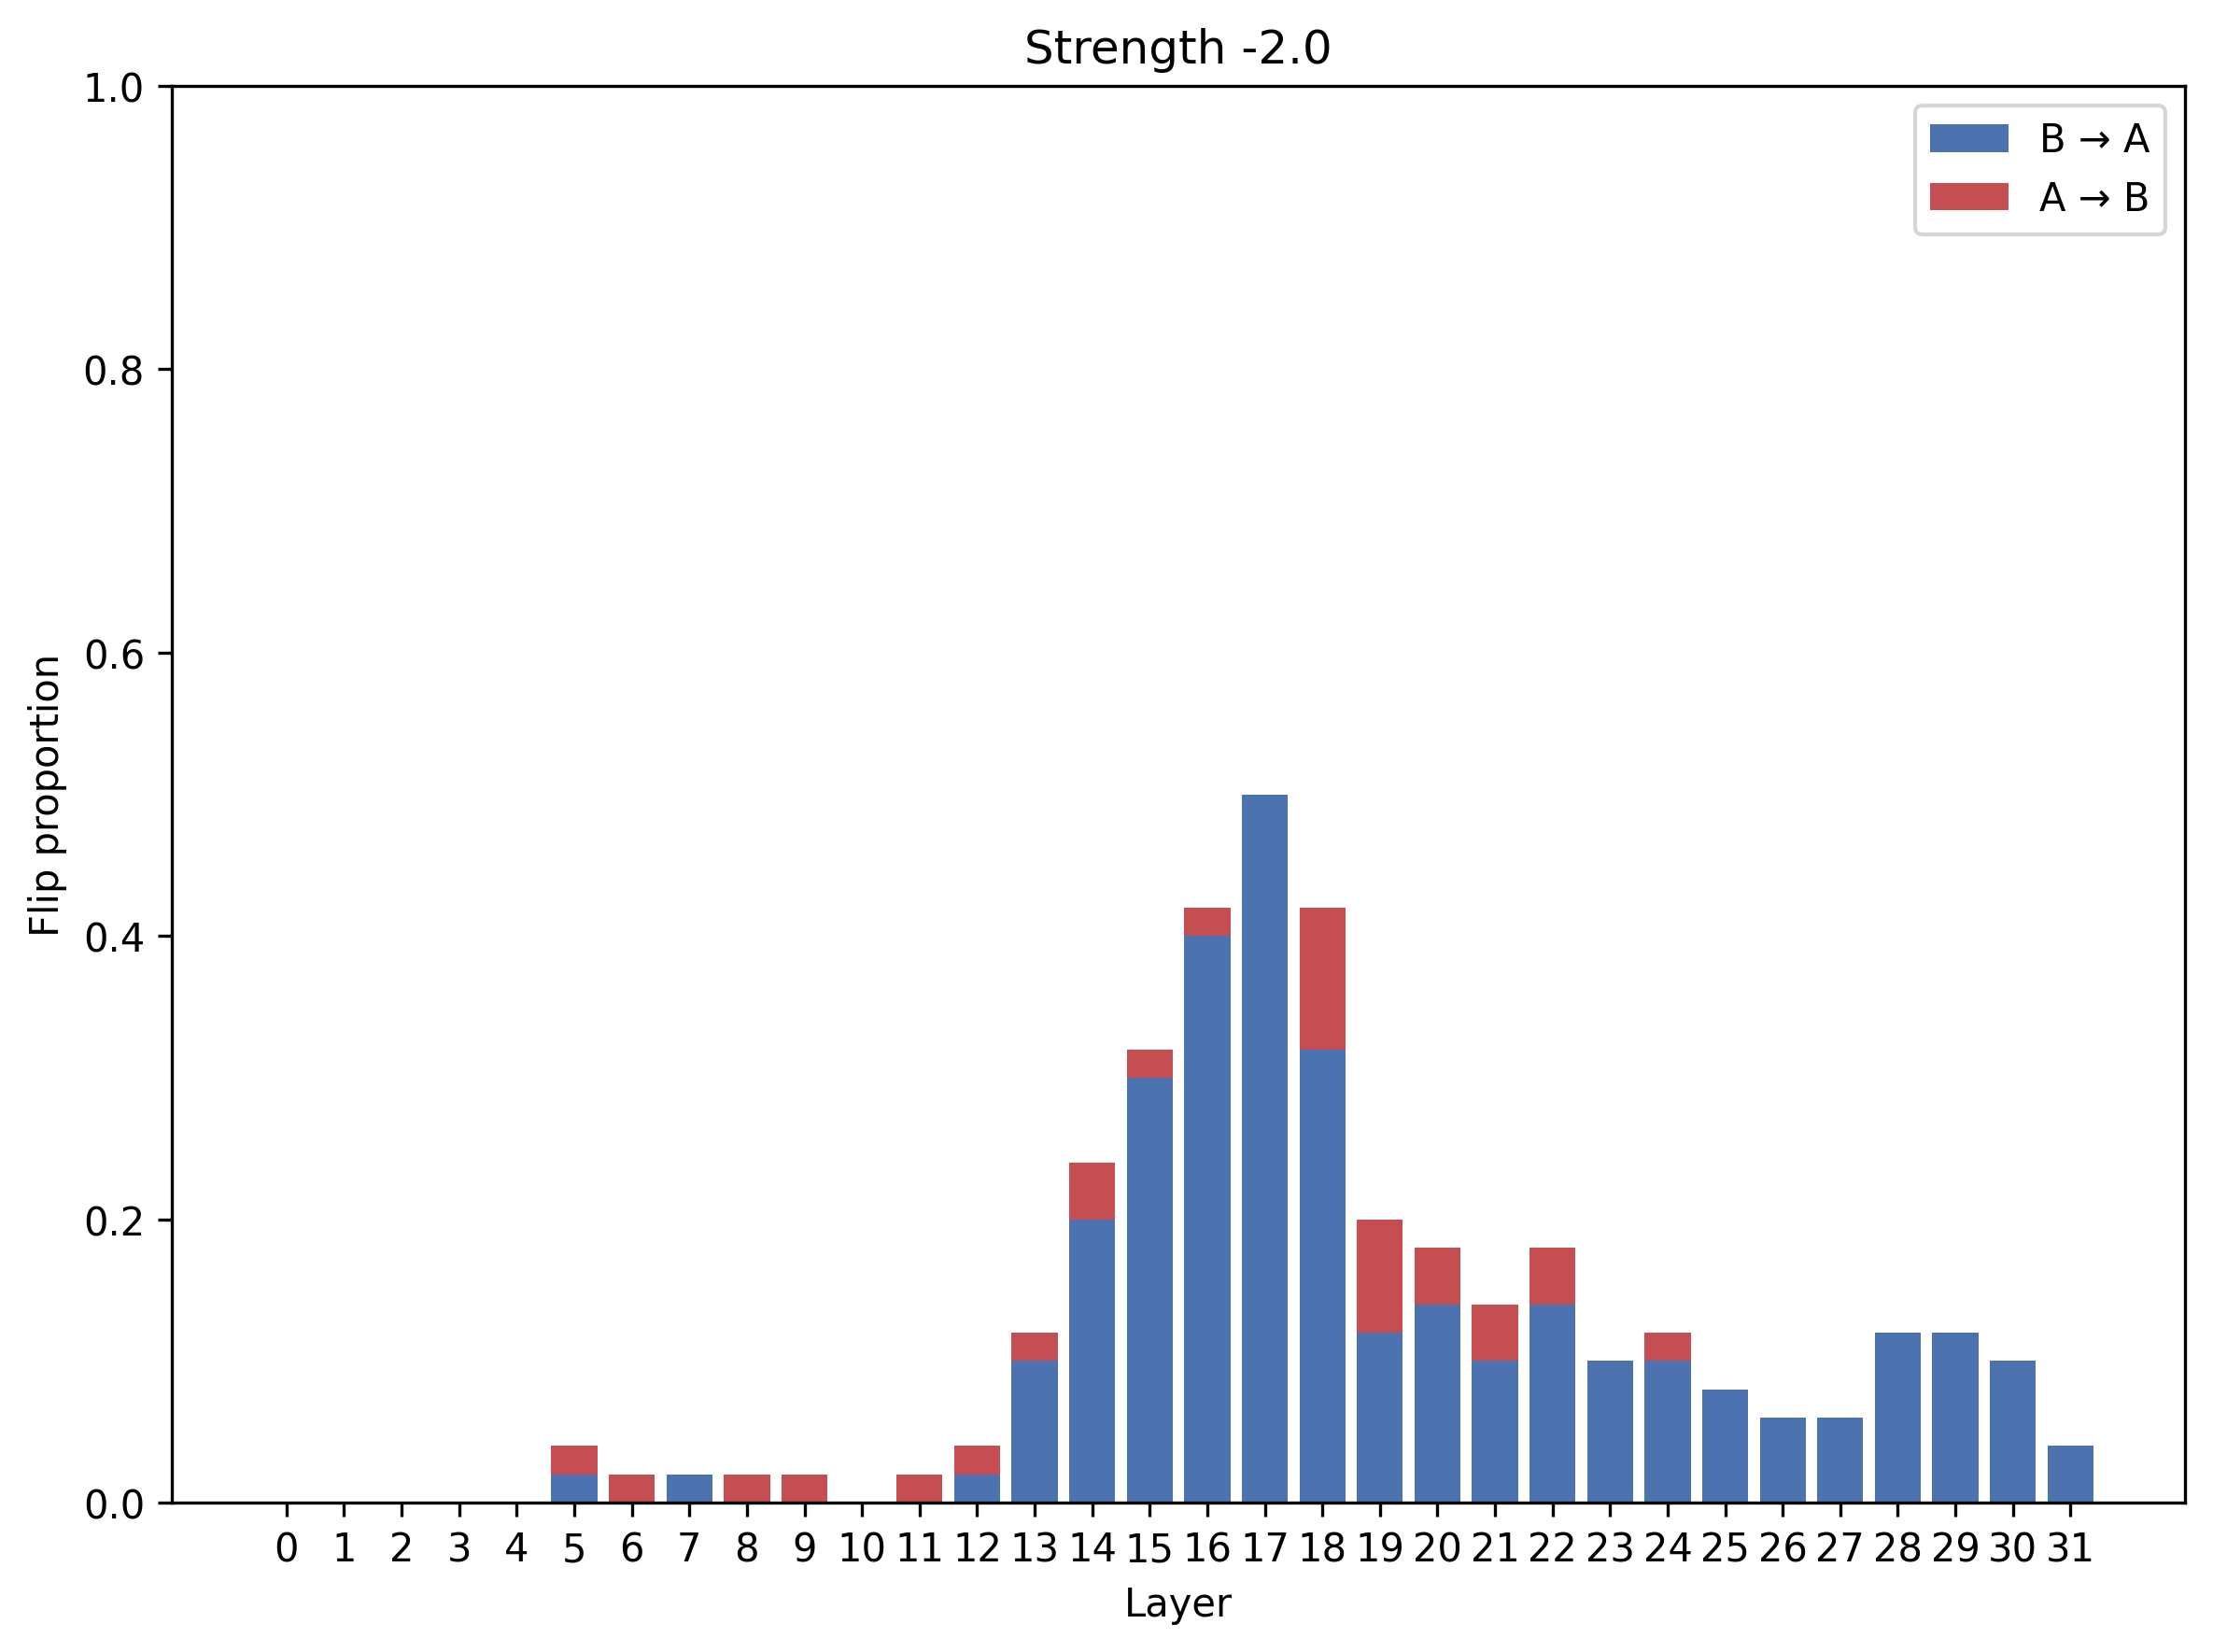

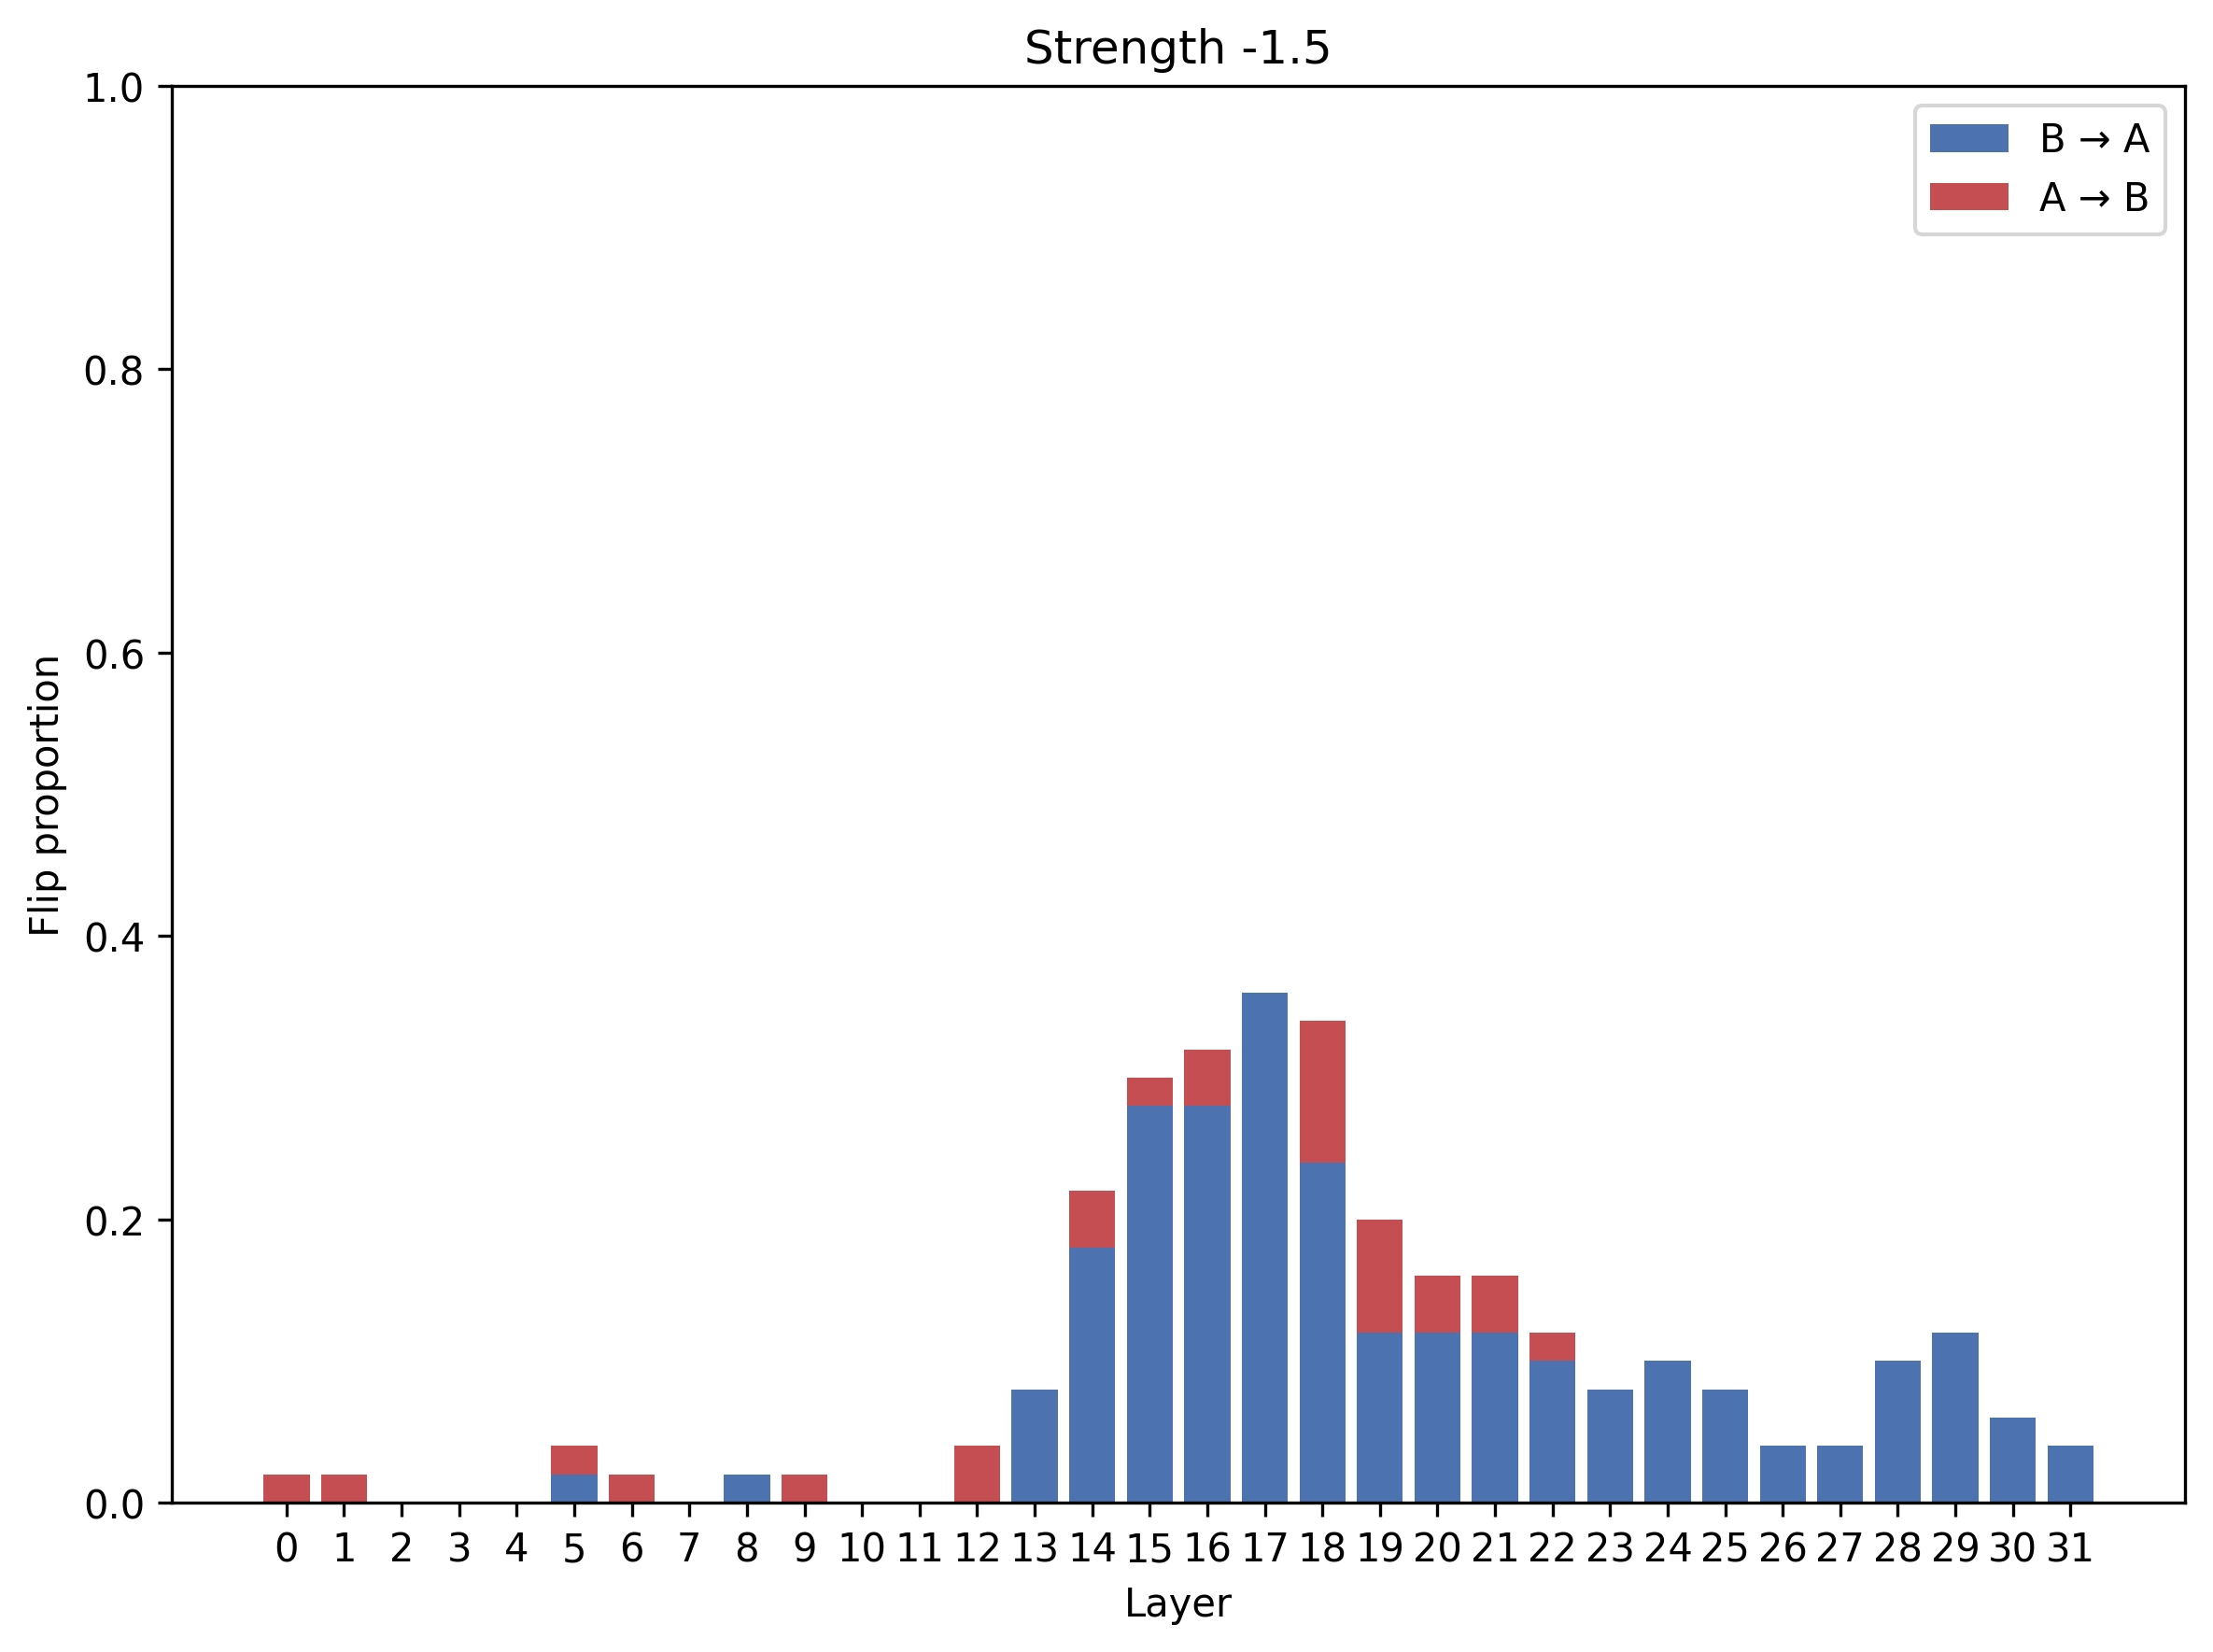

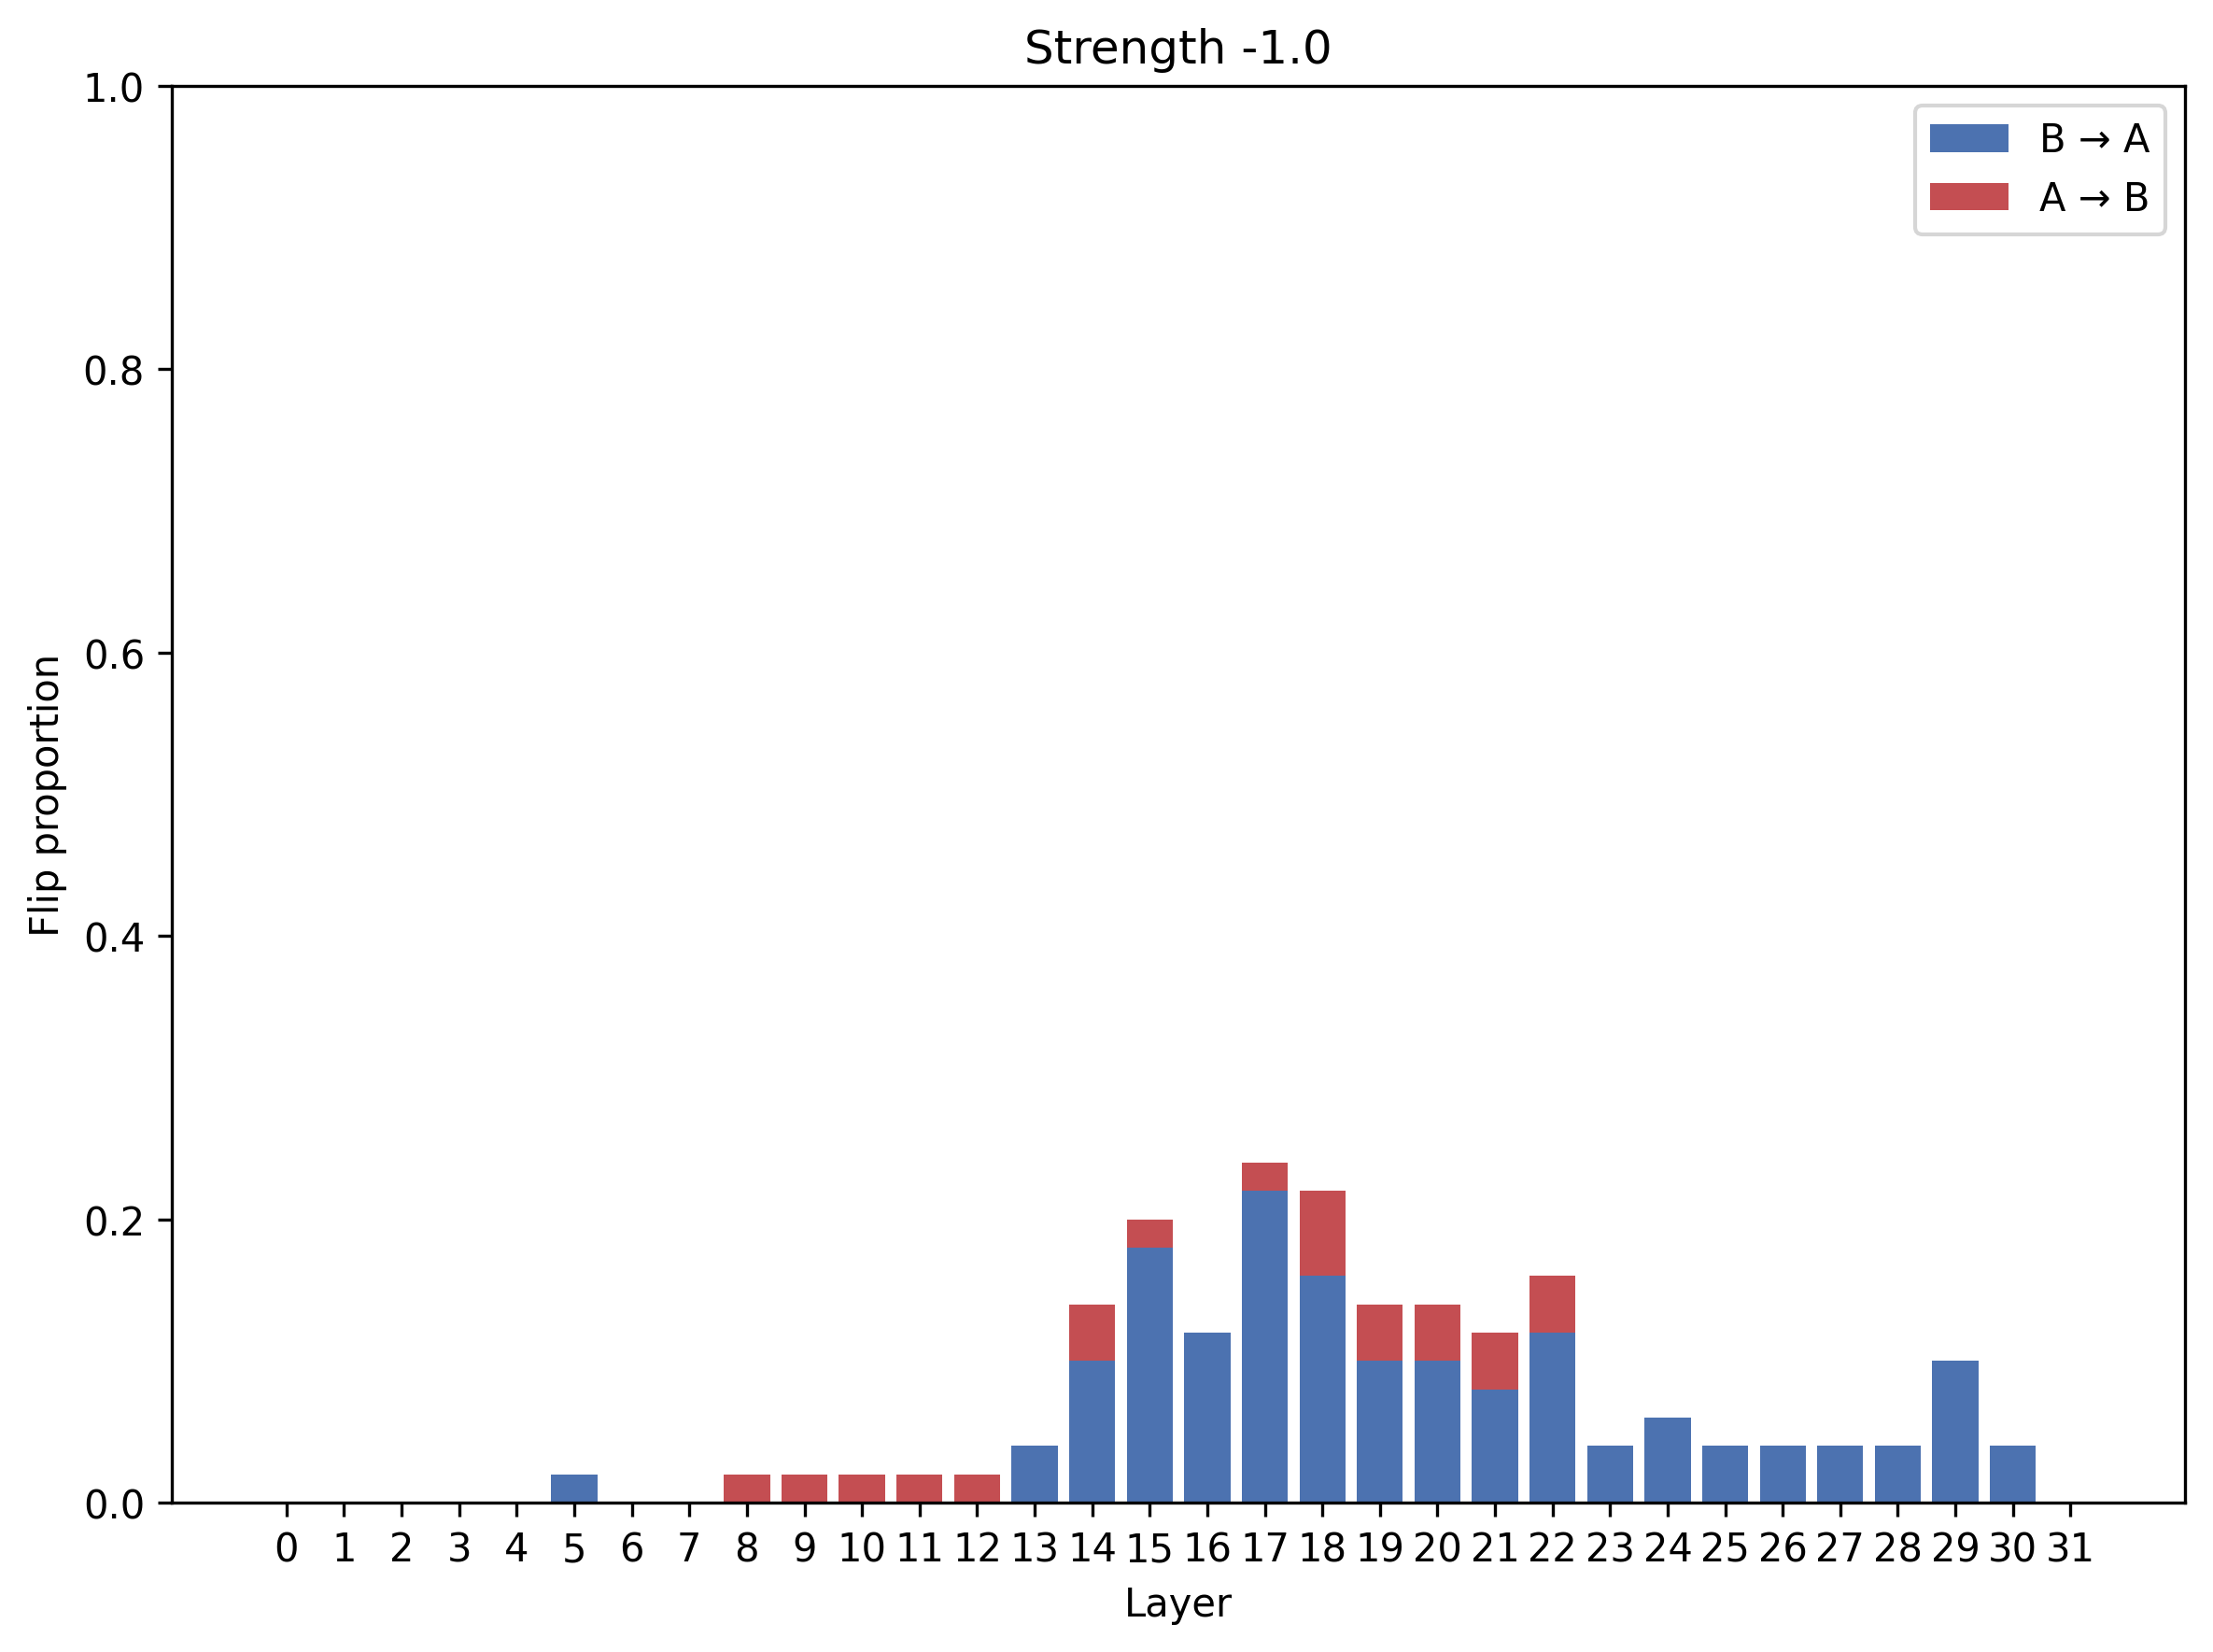

In [131]:
for i in [-2.0, -1.5, -1.0]:

    letter_flip_prop = steering_results[steering_results['strength'] == i].groupby(['layer']).agg({'flipped_to_control': 'sum', 'A_to_B': 'sum', 'treatment_text': 'count'})
    letter_flip_prop['flip_prop'] = letter_flip_prop['flipped_to_control'].astype(float) / letter_flip_prop['treatment_text']
    letter_flip_prop['flip_prop_B_to_A'] = (letter_flip_prop['flipped_to_control'] - letter_flip_prop['A_to_B']) / letter_flip_prop['treatment_text']

    fig, ax = plt.subplots(figsize=(8, 6))

    layers = letter_flip_prop.index
    ax.bar(layers, letter_flip_prop['flip_prop_B_to_A'], label='B → A', color='#4c72b0')
    ax.bar(layers, letter_flip_prop['flip_prop'] - letter_flip_prop['flip_prop_B_to_A'], bottom=letter_flip_prop['flip_prop_B_to_A'], label='A → B', color='#c44e52')

    ax.set_ylim(0, 1)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Flip proportion')
    ax.set_title(f'Strength {i}')
    ax.set_xticks(layers)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [96]:
df_switch_test[['control_resp','treatment_resp']].value_counts()

control_resp  treatment_resp
A             B                 25
B             A                 25
Name: count, dtype: int64

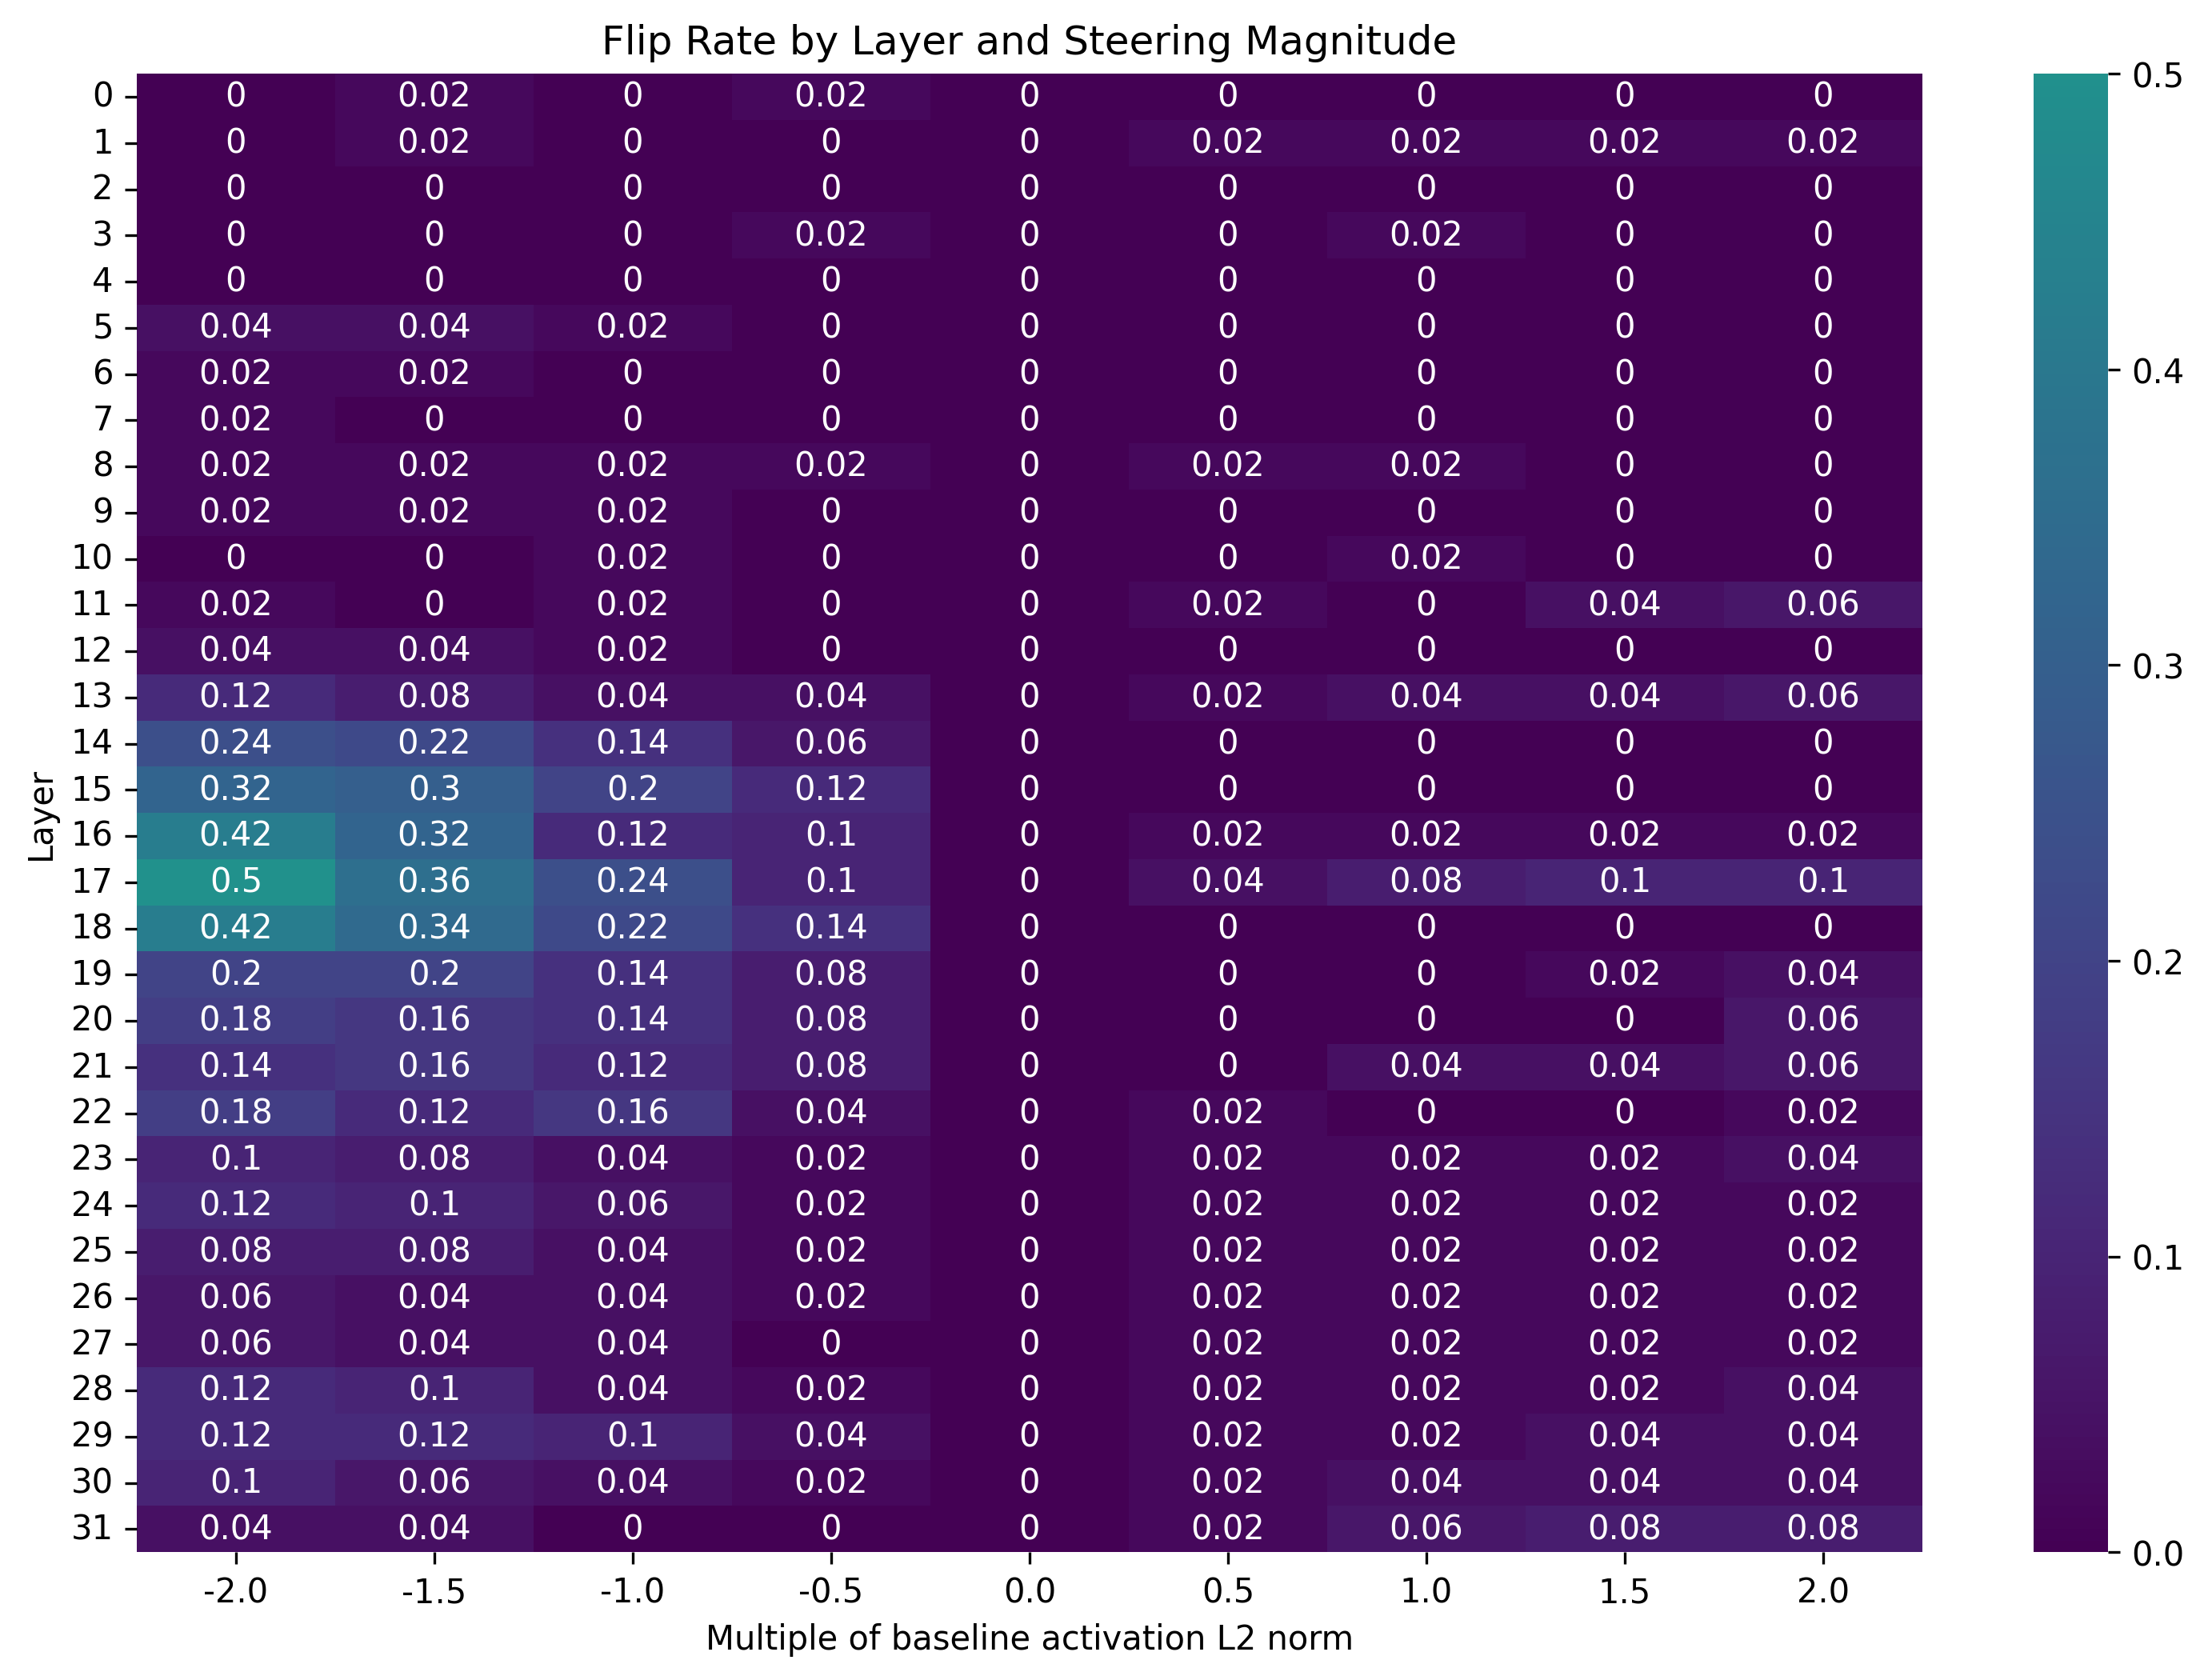

In [74]:
# create heatmap of flip rate by layer and strength
plt.figure(figsize=(12, 8))
sns.heatmap(steering_heatmap, annot=True, cmap='viridis', center=0.5)
plt.title('Flip Rate by Layer and Steering Magnitude')
plt.yticks(rotation=0)
plt.xlabel('Multiple of baseline activation L2 norm')
plt.ylabel('Layer')
plt.show()